In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import time
import psutil
import threading
from memory_profiler import memory_usage

In [ ]:
import glob

files = glob.glob('*TrafficForML_CICFlowMeter.csv')

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

df.to_csv('combined_traffic_data.csv', index=False)

C:\Users\Pavel\AppData\Local\Temp\ipykernel_13508\636553578.py:5: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)


In [ ]:
df.shape

(16233002, 84)

In [2]:
def apply_rf(X_train, y_train, best_params=None, random_state=42, n_jobs=-1, cv=5): 
    measurement_rf = {}
        
    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    rf_model = RandomForestClassifier(**best_params, random_state=random_state, n_jobs=n_jobs, verbose=1)
    
    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        rf_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_model()
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_rf['Training Time (s)'] = training_time
        measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_rf, measurement_rf, rf_model

    except Exception as e:
        import traceback
        print("⛔ Full error traceback:")
        traceback.print_exc()  # Print detailed error traceback
        print(f"Error during Random Forest training: {e}")
        return None, None, None

In [3]:
def eval_dataset_w_RF(df, target_column="Label"):
    X = df.drop(target_column, axis=1)
    y = df[target_column]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    params_rf = {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 8}

    # Fitting the model
    cv_scores_rf, measurement_rf, rf_model = apply_rf(X_train, y_train, best_params=params_rf)

    # Making predictions
    y_pred_rf = rf_model.predict(X_test)
    
    # Evaluating the model performance on the cross validation set vs accuracy on the test set
    cv_scores_mean_rf = np.mean(cv_scores_rf)
    print(f'Cross validation average score: {cv_scores_mean_rf:.4f} +/- standard deviation: {np.std(cv_scores_rf):.4f}')

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f'Accuracy on the test set: {accuracy_rf:.4f}')
    
    # Checking computational cost
    print("Resource measurements:", measurement_rf)
    print(classification_report(y_test, y_pred_rf))

In [31]:
def get_feature_types(df, target_col='Label'):
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

In [5]:
df = pd.read_csv("combined_traffic_data.csv")

C:\Users\Pavel\AppData\Local\Temp\ipykernel_25540\2503161614.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,80,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_traffic_data.csv")


In [6]:
df.shape

(16233002, 84)

In [7]:
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Flow ID,Src IP,Src Port,Dst IP
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,...,0.0,0.0,0.0,0.0,0.0,Benign,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232997,23,6,28/02/2018 11:59:12,3,1,1,0,0,0,0,...,0,0,0.0,0,0,Infilteration,NaN,NaN,NaN,NaN
16232998,425,6,28/02/2018 10:50:04,2,1,1,0,0,0,0,...,0,0,0.0,0,0,Infilteration,NaN,NaN,NaN,NaN
16232999,445,6,28/02/2018 12:52:55,732728,2,2,0,0,0,0,...,0,0,0.0,0,0,Benign,NaN,NaN,NaN,NaN
16233000,23,6,28/02/2018 11:10:50,22,1,1,0,0,0,0,...,0,0,0.0,0,0,Infilteration,NaN,NaN,NaN,NaN


In [8]:
df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16233002 entries, 0 to 16233001
Data columns (total 84 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           object 
 1   Protocol           object 
 2   Timestamp          object 
 3   Flow Duration      object 
 4   Tot Fwd Pkts       object 
 5   Tot Bwd Pkts       object 
 6   TotLen Fwd Pkts    object 
 7   TotLen Bwd Pkts    object 
 8   Fwd Pkt Len Max    object 
 9   Fwd Pkt Len Min    object 
 10  Fwd Pkt Len Mean   object 
 11  Fwd Pkt Len Std    object 
 12  Bwd Pkt Len Max    object 
 13  Bwd Pkt Len Min    object 
 14  Bwd Pkt Len Mean   object 
 15  Bwd Pkt Len Std    object 
 16  Flow Byts/s        object 
 17  Flow Pkts/s        object 
 18  Flow IAT Mean      object 
 19  Flow IAT Std       object 
 20  Flow IAT Max       object 
 21  Flow IAT Min       object 
 22  Fwd IAT Tot        object 
 23  Fwd IAT Mean       object 
 24  Fwd IAT Std        object 
 25  Fwd IAT Max     

In [10]:
# Dropping non helpful columns
df.drop(["Timestamp", "Flow ID", "Src IP", "Src Port", "Dst IP"], axis=1, inplace=True)

In [11]:
df.shape

(16233002, 79)

In [12]:
df.columns = df.columns.str.rstrip()
df.columns = df.columns.str.strip()

In [13]:
df.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

In [14]:
df["Label"].unique()[1:]

array(['Bot', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk', 'Label',
       'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection',
       'DDoS attacks-LOIC-HTTP', 'Infilteration', 'DoS attacks-GoldenEye',
       'DoS attacks-Slowloris', 'FTP-BruteForce', 'SSH-Bruteforce',
       'DDOS attack-LOIC-UDP', 'DDOS attack-HOIC'], dtype=object)

In [15]:
labels = df["Label"]
df.drop("Label", axis=1, inplace=True)
for column in df.columns:
   df[column] = pd.to_numeric(df[column], errors='coerce')
df["Label"] = labels
del labels

Features with at least one NaN or Infinity value:
Dst Port         59
Protocol         59
Flow Duration    59
Tot Fwd Pkts     59
Tot Bwd Pkts     59
                 ..
Active Min       59
Idle Mean        59
Idle Std         59
Idle Max         59
Idle Min         59
Length: 78, dtype: int64


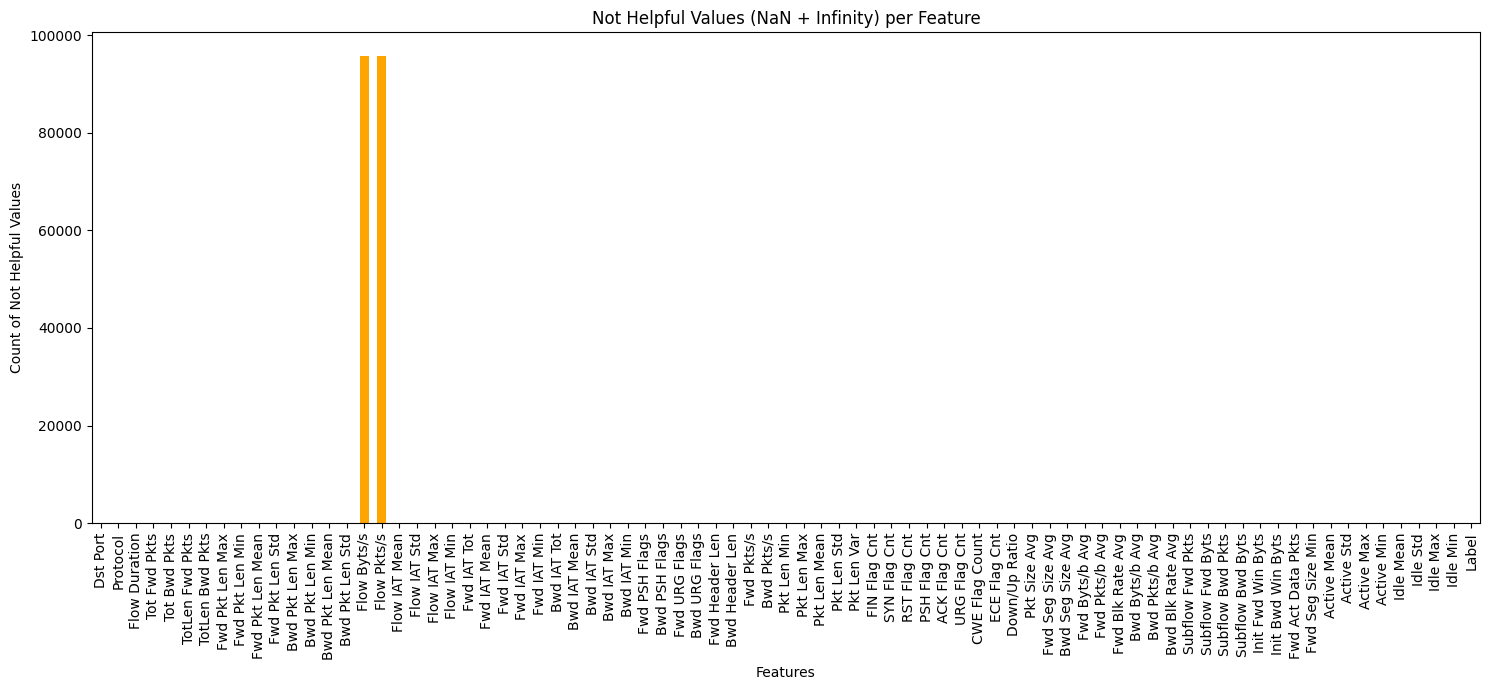

In [16]:
nan_counts = df.isna().sum()
def count_infs(col):
    if pd.api.types.is_numeric_dtype(col):
        return np.isinf(col).sum()
    else:
        return 0
inf_counts = df.apply(count_infs)
not_helpful_counts = nan_counts + inf_counts
features_with_issue = not_helpful_counts[not_helpful_counts > 0]
print("Features with at least one NaN or Infinity value:")
print(features_with_issue)
plt.figure(figsize=(15, 7))
not_helpful_counts.plot(kind='bar', color='orange')
plt.title("Not Helpful Values (NaN + Infinity) per Feature")
plt.xlabel("Features")
plt.ylabel("Count of Not Helpful Values")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Checking for infinite values
num_columns = df.select_dtypes(include = np.number).columns
has_infinite = np.isinf(df[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Byts/s    36039
Flow Pkts/s    95760
dtype: int64


In [18]:
# Treating infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
# Attack counts
attack_counts = df['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = df.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,Benign,13484708,13390249.0,94459.0,0.7
1,DDOS attack-HOIC,686012,686012.0,0.0,0.0
2,DDoS attacks-LOIC-HTTP,576191,576191.0,0.0,0.0
3,DoS attacks-Hulk,461912,461912.0,0.0,0.0
4,Bot,286191,286191.0,0.0,0.0
5,FTP-BruteForce,193360,193354.0,6.0,0.0
6,SSH-Bruteforce,187589,187589.0,0.0,0.0
7,Infilteration,161934,160639.0,1295.0,0.8
8,DoS attacks-SlowHTTPTest,139890,139890.0,0.0,0.0
9,DoS attacks-GoldenEye,41508,41508.0,0.0,0.0


In [20]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [21]:
row_missing_percentage = (df.isna().sum(axis=1) / df.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = df.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    1.623300e+07
mean     1.529327e-02
std      2.701965e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.873418e+01
dtype: float64

Total rows with missing values: 95819


In [22]:
# Dropping missing values
df = df.dropna()
print(f'Dataset shape after row-wise removal: {df.shape}')

Dataset shape after row-wise removal: (16137183, 79)


In [23]:
nan_counts = df.isna().sum()
inf_counts = df.apply(count_infs)
print("Features with NaNs")
print(nan_counts[nan_counts>0])
print("Features with Infs")
print(inf_counts[inf_counts>0])

Features with NaNs
Series([], dtype: int64)
Features with Infs
Series([], dtype: int64)


In [24]:
df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443.0,6.0,141385.0,9.0,7.0,553.0,3773.0,202.0,0.0,61.444444,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684.0,6.0,281.0,2.0,1.0,38.0,0.0,38.0,0.0,19.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443.0,6.0,279824.0,11.0,15.0,1086.0,10527.0,385.0,0.0,98.727273,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443.0,6.0,132.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443.0,6.0,274016.0,9.0,13.0,1285.0,6141.0,517.0,0.0,142.777778,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232997,23.0,6.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infilteration
16232998,425.0,6.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infilteration
16232999,445.0,6.0,732728.0,2.0,2.0,0.0,0.0,0.0,0.0,0.000000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
16233000,23.0,6.0,22.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infilteration


In [25]:
df.shape

(16137183, 79)

In [26]:
row_missing_percentage = (df.isna().sum(axis=1) / df.shape[1]) * 100
print(row_missing_percentage.describe())

count    16137183.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
dtype: float64


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16137183 entries, 0 to 16137182
Data columns (total 79 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           float32
 1   Protocol           float32
 2   Flow Duration      float32
 3   Tot Fwd Pkts       float32
 4   Tot Bwd Pkts       float32
 5   TotLen Fwd Pkts    float32
 6   TotLen Bwd Pkts    float32
 7   Fwd Pkt Len Max    float32
 8   Fwd Pkt Len Min    float32
 9   Fwd Pkt Len Mean   float32
 10  Fwd Pkt Len Std    float32
 11  Bwd Pkt Len Max    float32
 12  Bwd Pkt Len Min    float32
 13  Bwd Pkt Len Mean   float32
 14  Bwd Pkt Len Std    float32
 15  Flow Byts/s        float32
 16  Flow Pkts/s        float32
 17  Flow IAT Mean      float32
 18  Flow IAT Std       float32
 19  Flow IAT Max       float32
 20  Flow IAT Min       float32
 21  Fwd IAT Tot        float32
 22  Fwd IAT Mean       float32
 23  Fwd IAT Std        float32
 24  Fwd IAT Max        float32
 25  Fwd IAT Min     

In [10]:
labels = df["Label"]
df.drop("Label", axis=1, inplace=True)
df = df.astype(np.float32)
df["Label"] = labels
del labels

In [12]:
df.to_csv('combined_data_fixed_f32.csv', index=False)

In [5]:
df = pd.read_csv("combined_data_fixed_f32.csv")

In [6]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 10.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:   25.7s finished


Cross validation average score: 0.9805 +/- standard deviation: 0.0004
Accuracy on the test set: 0.9819
Resource measurements: {'Training Time (s)': 621.127115726471, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 94.86844181459566}


c:\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

                  Benign       0.99      1.00      0.99   4017075
                     Bot       0.95      0.99      0.97     85857
        Brute Force -Web       0.00      0.00      0.00       183
        Brute Force -XSS       1.00      0.45      0.62        69
        DDOS attack-HOIC       1.00      1.00      1.00    205804
    DDOS attack-LOIC-UDP       0.82      0.97      0.89       519
  DDoS attacks-LOIC-HTTP       1.00      0.97      0.99    172857
   DoS attacks-GoldenEye       1.00      0.99      1.00     12452
        DoS attacks-Hulk       1.00      1.00      1.00    138574
DoS attacks-SlowHTTPTest       0.76      0.51      0.61     41967
   DoS attacks-Slowloris       1.00      0.76      0.86      3297
          FTP-BruteForce       0.71      0.88      0.79     58006
           Infilteration       0.00      0.00      0.00     48192
           SQL Injection       0.00      0.00      0.00        26
         

c:\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

[]

In [8]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))
df['Label'].value_counts()

Label
Benign                      13390249
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193354
SSH-Bruteforce                187589
Infilteration                 160639
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: count, dtype: int64

In [9]:
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

In [10]:
print(f"Original shape: {df.shape}")
df = df.drop_duplicates(keep='first')
print(f"Without duplicate rows shape: {df.shape}")

Original shape: (16137183, 79)
Without duplicate rows shape: (11445955, 79)


In [11]:
identical_columns = {}
columns = df.columns
list_control = columns.copy().tolist()

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if df[col1].equals(df[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Tot Fwd Pkts' is identical to ['Subflow Fwd Pkts']
'Tot Bwd Pkts' is identical to ['Subflow Bwd Pkts']
'TotLen Fwd Pkts' is identical to ['Subflow Fwd Byts']
'Fwd Pkt Len Mean' is identical to ['Fwd Seg Size Avg']
'Bwd Pkt Len Mean' is identical to ['Bwd Seg Size Avg']
'Fwd PSH Flags' is identical to ['SYN Flag Cnt']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg']
'Fwd URG Flags' is identical to ['CWE Flag Count']


In [12]:
for key, value in identical_columns.items():
    df.drop(columns=value, inplace=True)

C:\Users\ogoreltsev.pav\AppData\Local\Temp\ipykernel_16296\2071412370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=value, inplace=True)
C:\Users\ogoreltsev.pav\AppData\Local\Temp\ipykernel_16296\2071412370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=value, inplace=True)
C:\Users\ogoreltsev.pav\AppData\Local\Temp\ipykernel_16296\2071412370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [13]:
df.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio',
       'Pkt Size Avg', 'Subflow Bwd Byts', 'Init Fwd Win Byts',
       'Init Bwd Win Byts', '

In [14]:
df.shape

(11445955, 65)

In [15]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


In [16]:
# Dropping the columns with only one unique value
df.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [17]:
df.shape

(11445955, 64)

In [18]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:   22.3s finished


Cross validation average score: 0.9856 +/- standard deviation: 0.0002
Accuracy on the test set: 0.9842
Resource measurements: {'Training Time (s)': 458.7658591270447, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 97.97894736842105}


c:\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

                  Benign       0.98      1.00      0.99   3028546
                     Bot       1.00      0.99      0.99     43361
        Brute Force -Web       0.00      0.00      0.00       166
        Brute Force -XSS       1.00      0.50      0.67        68
        DDOS attack-HOIC       1.00      0.90      0.95     59658
    DDOS attack-LOIC-UDP       0.77      0.98      0.86       519
  DDoS attacks-LOIC-HTTP       1.00      0.98      0.99    172504
   DoS attacks-GoldenEye       1.00      0.99      1.00     12418
        DoS attacks-Hulk       1.00      1.00      1.00     43560
DoS attacks-SlowHTTPTest       0.00      0.00      0.00        16
   DoS attacks-Slowloris       1.00      0.72      0.84      2914
          FTP-BruteForce       0.00      0.00      0.00        16
           Infilteration       1.00      0.00      0.00     41802
           SQL Injection       0.00      0.00      0.00        25
         

c:\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
# Mapping the attacks to the new group
group_mapping = {
    'Benign': 'Normal Traffic',
    'Brute Force -Web': 'Brute Force',
    'Brute Force -XSS': 'Brute Force',
    'FTP-BruteForce': 'Brute Force',
    'SSH-Bruteforce': 'Brute Force',
    'DDOS attack-HOIC': 'DDoS',
    'DDOS attack-LOIC-UDP': 'DDoS',
    'DDoS attacks-LOIC-HTTP': 'DDoS',
    'DoS attacks-GoldenEye': 'DoS',
    'DoS attacks-Hulk': 'DoS',
    'DoS attacks-SlowHTTPTest': 'DoS',
    'DoS attacks-Slowloris': 'DoS',
    'Bot': 'Bot',
    'SQL Injection': 'SQL Injection',
    'Infilteration': 'Infilteration',
}

# Map to new group column
df['Attack Type'] = df['Label'].map(group_mapping)

In [20]:
print(df['Attack Type'].value_counts())
df.drop(columns='Label', inplace=True)

Attack Type
Normal Traffic    10095152
DDoS                775603
DoS                 196358
Bot                 144535
Infilteration       139341
Brute Force          94882
SQL Injection           84
Name: count, dtype: int64


In [21]:
df.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
0,443.0,6.0,141385.0,9.0,7.0,553.0,3773.0,202.0,0.0,61.444443,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
1,49684.0,6.0,281.0,2.0,1.0,38.0,0.0,38.0,0.0,19.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
2,443.0,6.0,279824.0,11.0,15.0,1086.0,10527.0,385.0,0.0,98.727270,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
3,443.0,6.0,132.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
4,443.0,6.0,274016.0,9.0,13.0,1285.0,6141.0,517.0,0.0,142.777770,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic


In [22]:
# Removing rows with statistically irrelevant attack types
df.drop(df[(df['Attack Type'] == 'SQL Injection')].index, inplace=True)

In [23]:
# Data shape and attack counts after removal
print(df.shape)
df['Attack Type'].value_counts()

(11445871, 64)


Attack Type
Normal Traffic    10095152
DDoS                775603
DoS                 196358
Bot                 144535
Infilteration       139341
Brute Force          94882
Name: count, dtype: int64

In [24]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df, target_column='Attack Type')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   11.1s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:   17.6s finished


Cross validation average score: 0.9857 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9857
Resource measurements: {'Training Time (s)': 428.5648798942566, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 95.36385542168675}
                precision    recall  f1-score   support

           Bot       1.00      0.99      0.99     43361
   Brute Force       1.00      0.99      1.00     28465
          DDoS       1.00      0.98      0.99    232681
           DoS       1.00      1.00      1.00     58907
 Infilteration       0.73      0.00      0.00     41802
Normal Traffic       0.98      1.00      0.99   3028546

      accuracy                           0.99   3433762
     macro avg       0.95      0.83      0.83   3433762
  weighted avg       0.98      0.99      0.98   3433762



# Correlation Analysis

In [25]:
import seaborn as sns

In [26]:
def correlation_analysis(df, numeric_features, threshold=0.85):
    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth = 0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identify highly correlated features
    threshold = threshold
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

In [33]:
df.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'FIN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts

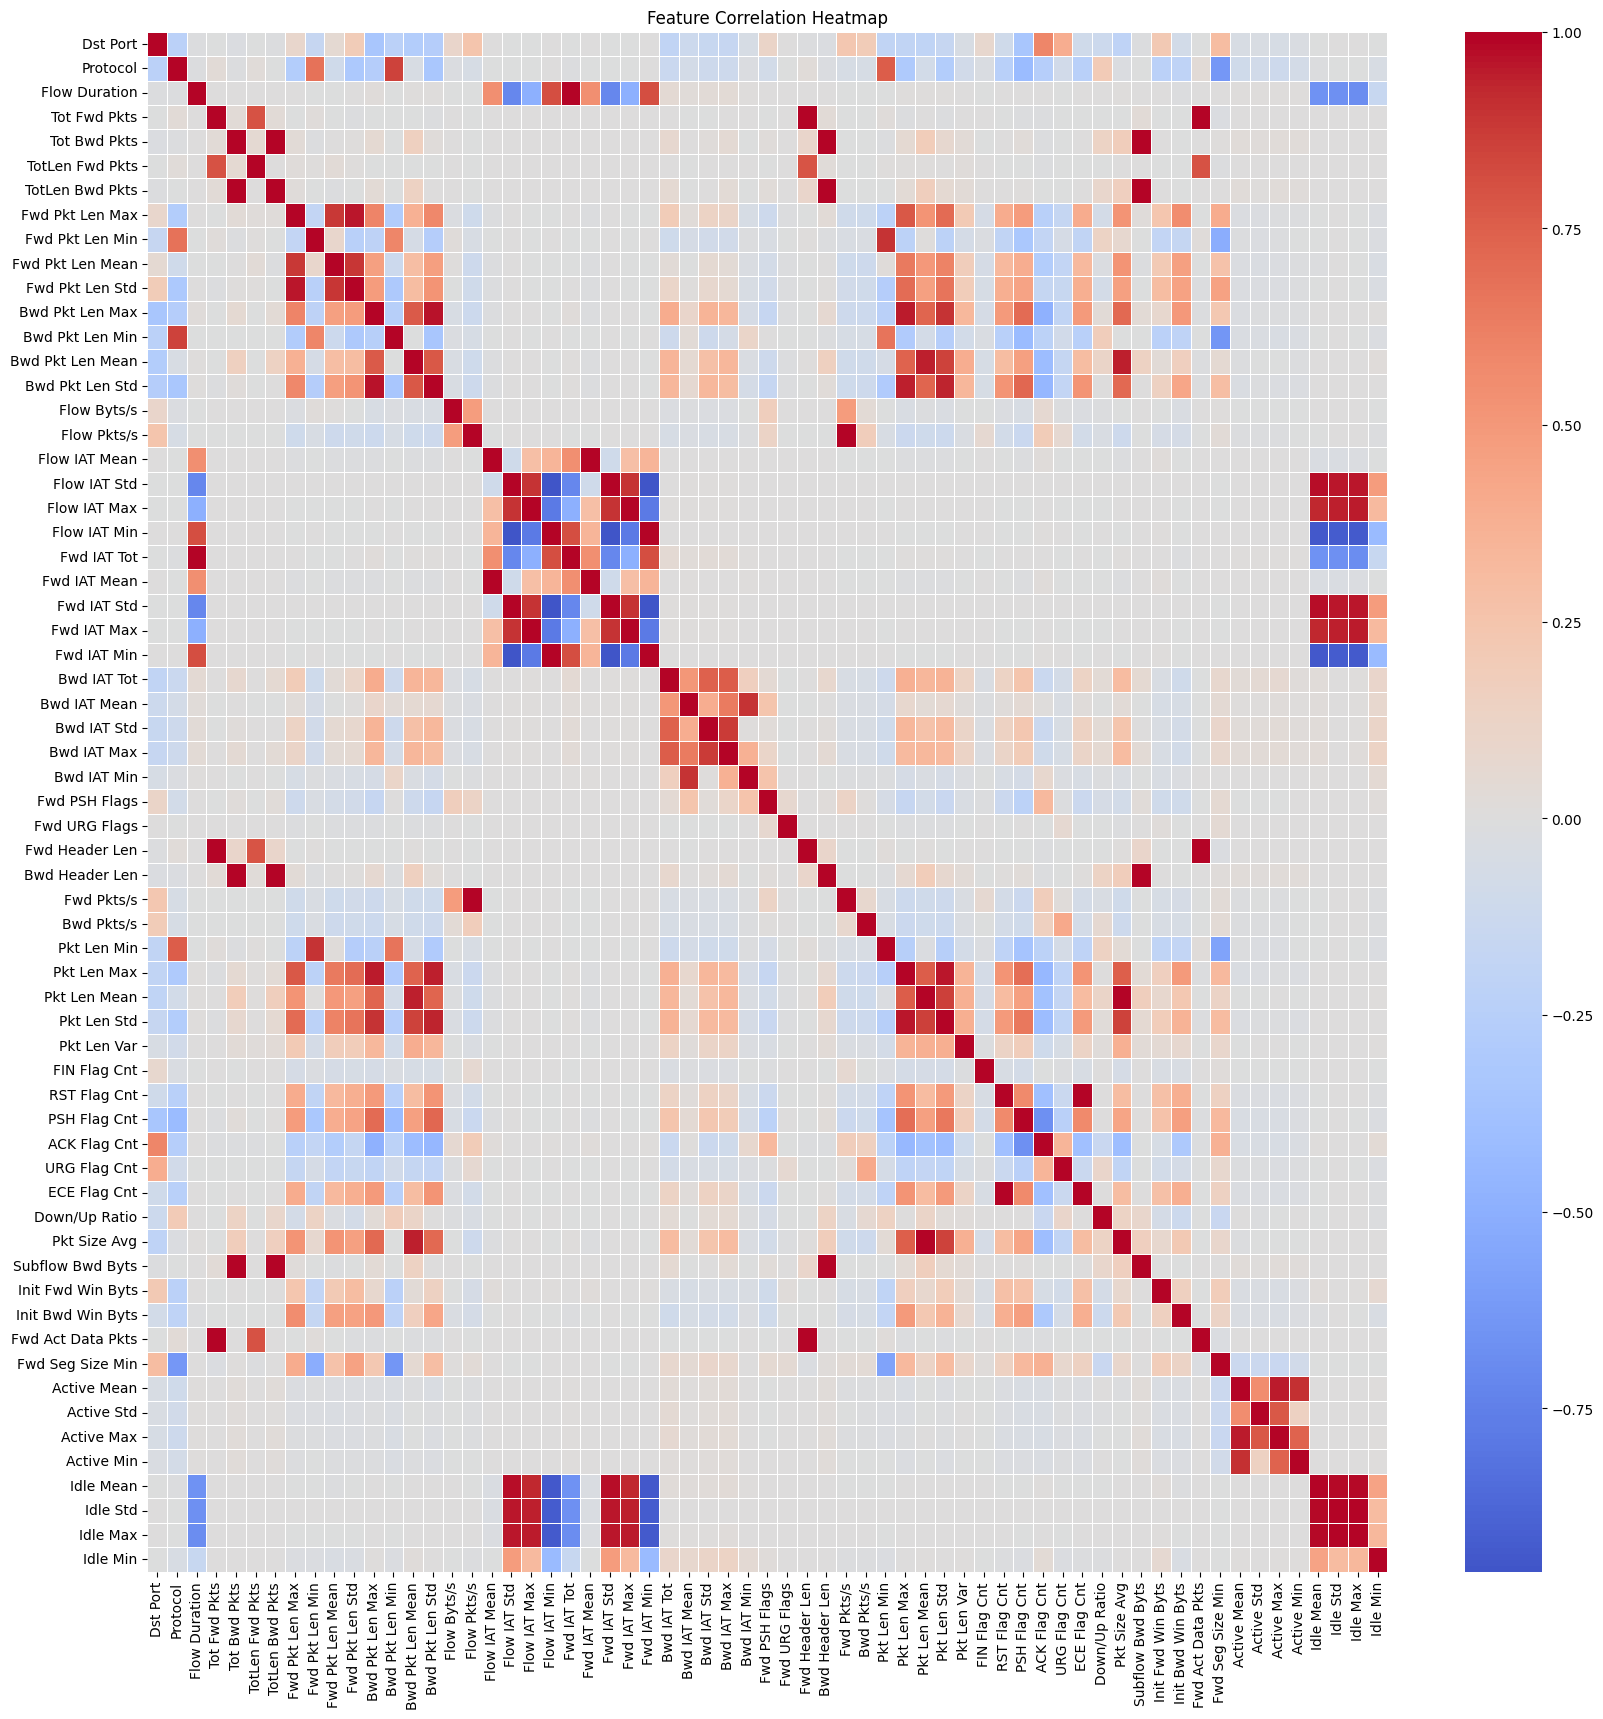

In [34]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(df, target_col='Attack Type')
high_corr = correlation_analysis(df, numeric_features)

In [35]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Protocol has a high correlation with Bwd Pkt Len Min: 0.8514
Flow Duration has a high correlation with Fwd IAT Tot: 1.0
Tot Fwd Pkts has a high correlation with Fwd Header Len: 0.9956
Tot Fwd Pkts has a high correlation with Fwd Act Data Pkts: 0.9992
Tot Bwd Pkts has a high correlation with TotLen Bwd Pkts: 0.9936
Tot Bwd Pkts has a high correlation with Bwd Header Len: 0.9978
Tot Bwd Pkts has a high correlation with Subflow Bwd Byts: 0.9936
TotLen Bwd Pkts has a high correlation with Bwd Header Len: 0.9961
TotLen Bwd Pkts has a high correlation with Subflow Bwd Byts: 1.0
Fwd Pkt Len Max has a high correlation with Fwd Pkt Len Mean: 0.8796
Fwd Pkt Len Max has a high correlation with Fwd Pkt Len Std: 0.9547
Fwd Pkt Len Min has a high correlation with Pkt Len Min: 0.8943
Fwd Pkt Len Mean has a high correlation with Fwd Pkt Len Std: 0.8911
Bwd Pkt Len Max has a high correlation with Bwd Pkt Len Std: 0.9661
Bwd Pkt Len Max has a high correlation with Pkt Len Max: 0.9496
Bwd Pkt Len Max has

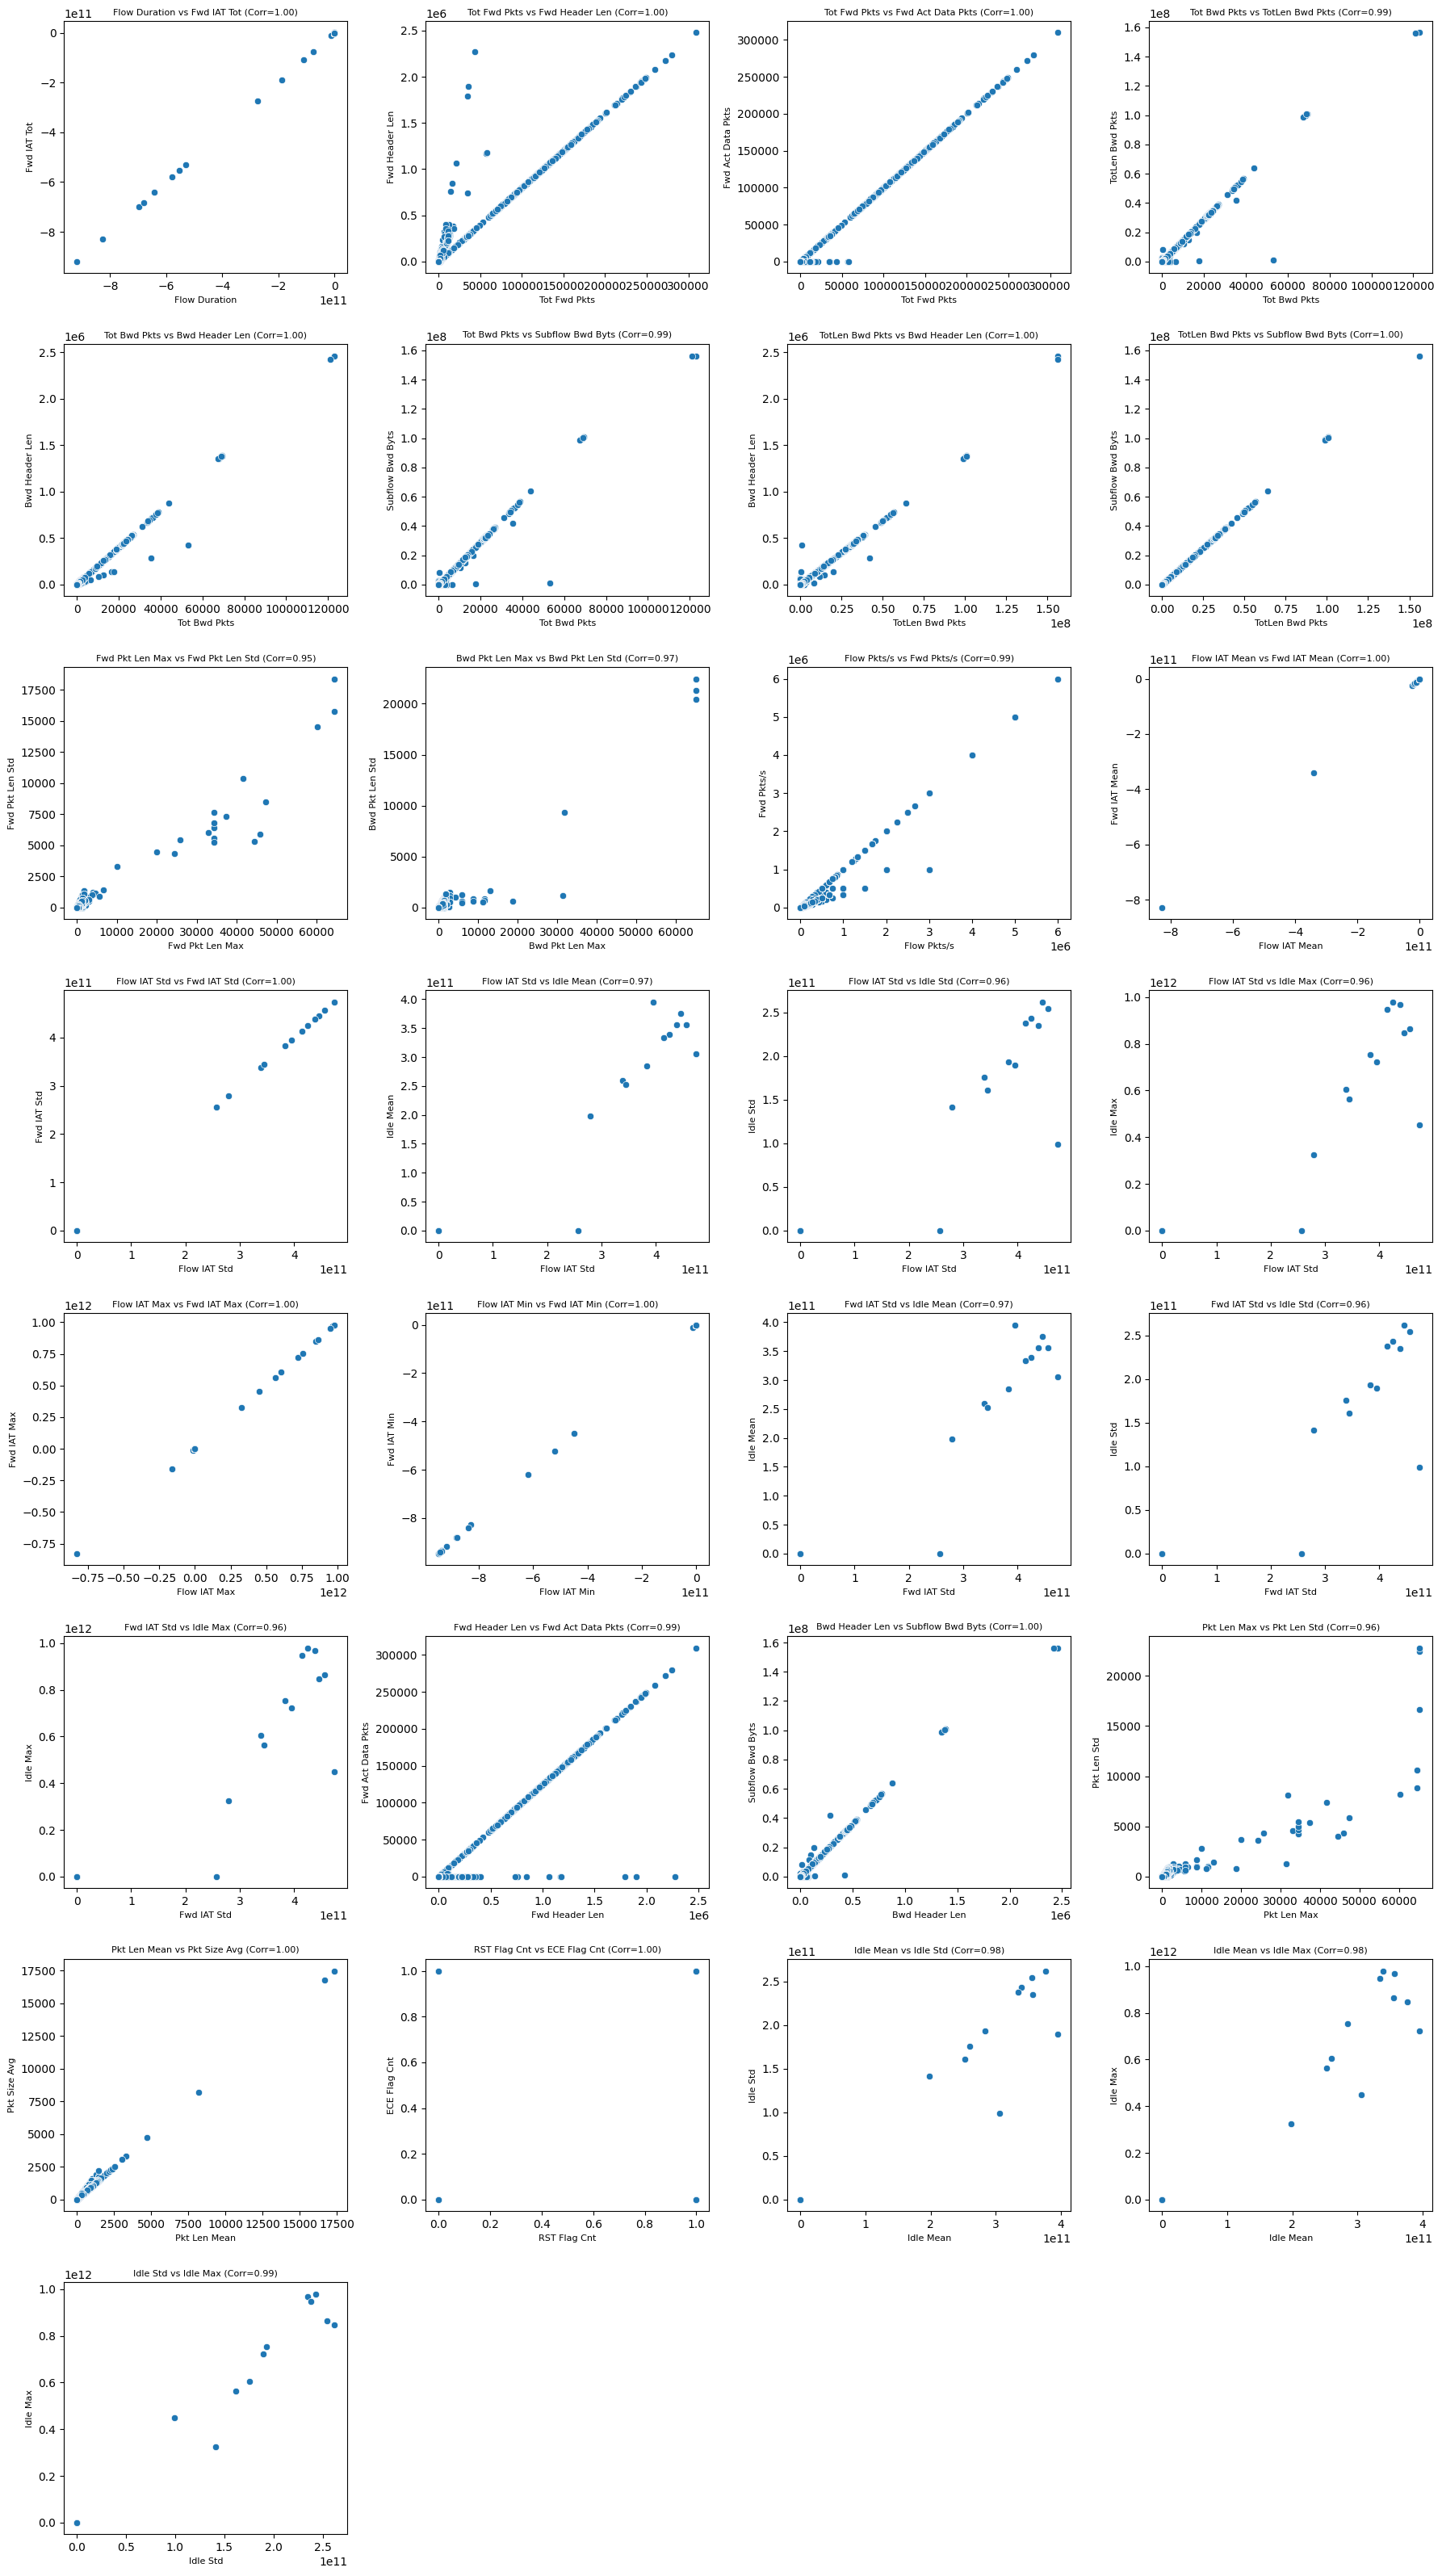

In [36]:
# Plotting the pairs with very high correlation for better visualization
n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=df[feature_x], y=df[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [30]:
df.to_csv('cicids2018_before_corr_analysis.csv', index=False)

In [37]:
# Removal of columns based on correlation analysis
selected_columns = ['Fwd IAT Tot', 'Fwd Header Len', 'Fwd Act Data Pkts', 'Subflow Bwd Byts', 'Bwd Header Len', 'Fwd IAT Std', 'Fwd IAT Mean', 'TotLen Bwd Pkts', 'Fwd Act Data Pkts', 'Pkt Size Avg', 'Fwd Act Data Pkts', 'Fwd Pkts/s']

# dropping columns with perfect/near perfect multicollinearity
df.drop(columns=selected_columns, inplace=True)

In [38]:
# Updating the variables and checking dataset shape
numeric_features, categorical_features = get_feature_types(df, target_col='Attack Type')
df.shape

(11445871, 54)

In [39]:
# Result of RF after droped features with high correlation
eval_dataset_w_RF(df, target_column='Attack Type')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:   11.9s finished


Cross validation average score: 0.9865 +/- standard deviation: 0.0000
Accuracy on the test set: 0.9864
Resource measurements: {'Training Time (s)': 401.3000473976135, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 92.06181262729125}
                precision    recall  f1-score   support

           Bot       1.00      0.99      0.99     43361
   Brute Force       1.00      0.99      0.99     28465
          DDoS       1.00      0.99      0.99    232681
           DoS       1.00      1.00      1.00     58907
 Infilteration       0.69      0.00      0.00     41802
Normal Traffic       0.99      1.00      0.99   3028546

      accuracy                           0.99   3433762
     macro avg       0.95      0.83      0.83   3433762
  weighted avg       0.98      0.99      0.98   3433762



# Outliers

In [40]:
def calculate_outliers_percentage(df):
    outlier_percentages = {}  # empty dictionary to store outlier percentages

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # first quartile (Q1) for the column
        Q3 = df[column].quantile(0.75)  # third quartile (Q3) for the column
        IQR = Q3 - Q1  # Interquartile Range (IQR)

        lower_bound = Q1 - 1.5 * IQR  # lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # upper bound for outliers

        # Identify outliers in the column
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate the percentage of outliers for the column
        outlier_percentage = len(outliers) / len(df) * 100

        # Store the outlier percentage in the dictionary
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages

<Figure size 1500x1000 with 0 Axes>

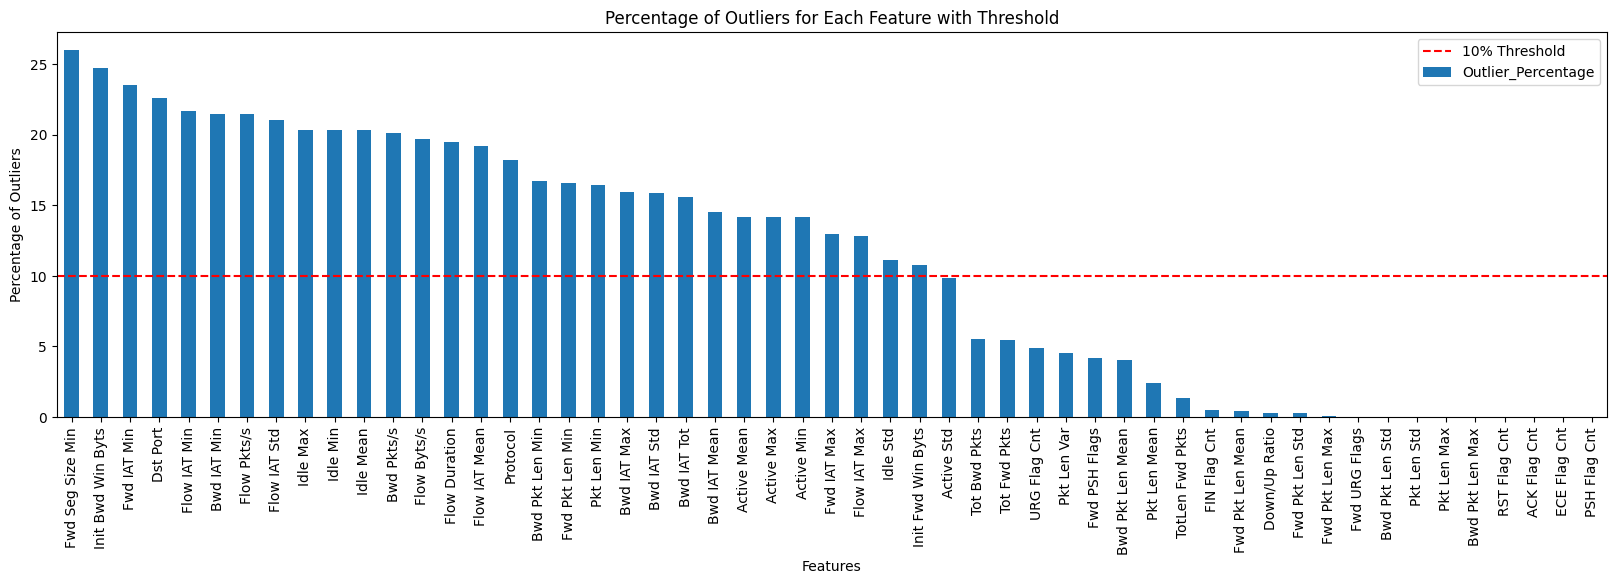

In [41]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(df[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

# Data Distribution

In [42]:
from scipy import stats

In [43]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:

    # Perform Anderson-Darling test for normality
    result = stats.anderson(df[col], dist='norm')

    # Compare the statistic with the critical value at 5% significance level
    if result.statistic < result.critical_values[2]:  # 5% significance level
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features are normally distributed')
print(f'{not_norm_dist} features are not normally distributed')

0 features are normally distributed
53 features are not normally distributed


# Class imbalance

In [44]:
# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = df['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic               10095152       88.20
1            DDoS                 775603        6.78
2             DoS                 196358        1.72
3             Bot                 144535        1.26
4   Infilteration                 139341        1.22
5     Brute Force                  94882        0.83


In [45]:
# Cleaning up
del attack_counts_df

# Feature Importance

In [46]:
def analyze_variance_homogeneity(df, numeric_features, target_col='Attack Type'):  
    results_levene = {}  
    
    for feature in numeric_features:  
        # Group data by y and filter out groups with zero values  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)   
                  if not group[feature].dropna().empty]  
        
        # Filter out groups that contain only zero values or have zero variance  
        groups = [group for group in groups if len(group) > 0 and np.any(group != 0) and np.var(group) > 0]  
        
        # Check if there are at least two groups with valid data  
        if len(groups) < 2:  
            print(f"Not enough valid groups to perform Levene's test for feature: {feature}")  
            continue  # Skip this feature if not enough valid groups  

        # Perform Levene's Test  
        stat_levene, p_value_levene = stats.levene(*groups)  
        results_levene[feature] = {'Statistic': stat_levene, 'p-value': p_value_levene}  

    return results_levene

In [47]:
# Applying the Levene's Test
# p-value < 0.05 suggests unequal variances among groups (rejecting the null hypothesis of equal variances)
variance_result = analyze_variance_homogeneity(df, numeric_features)

In [48]:
# Analysing the results
no_significant_results = True

for feature, result in variance_result.items():   
    if result['p-value'] > 0.05:  
        print(f"\nFeature: {feature}")  
        print(f"  - Test Statistic: {result['Statistic']:.4f}")  
        print(f"  - p-value: {result['p-value']:.4f}")  
        print("  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).")  
        no_significant_results = False

# If no features had p-values > 0.05  
if no_significant_results:  
    print("\nNo features have p-values greater than 0.05. All features have significant differences in variance.")


Feature: Idle Std
  - Test Statistic: 0.2785
  - p-value: 0.8920
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).


In [49]:
def analyze_feature_importance(df, numeric_features, target_col='Attack Type'):
    h_scores = {}  
    
    for feature in numeric_features:  
        # Group data by y and perform the Kruskal-Wallis test  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)]  
        h_stat, p_val = stats.kruskal(*groups)  
        h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}  

    # Create a DataFrame from the results  
    h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')  
    h_scores_df = h_scores_df.sort_values('H-statistic', ascending=False)  

    # Plotting H-statistics  
    plt.figure(figsize=(18, 10))  
    plt.bar(range(len(h_scores_df)), h_scores_df['H-statistic'], color='skyblue')  
    plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)  
    plt.title('Feature Importance based on H-statistic (Kruskal-Wallis Test)')  
    plt.xlabel('Features')  
    plt.ylabel('H-statistic')  
    plt.tight_layout()  
    plt.show()  

    return h_scores_df

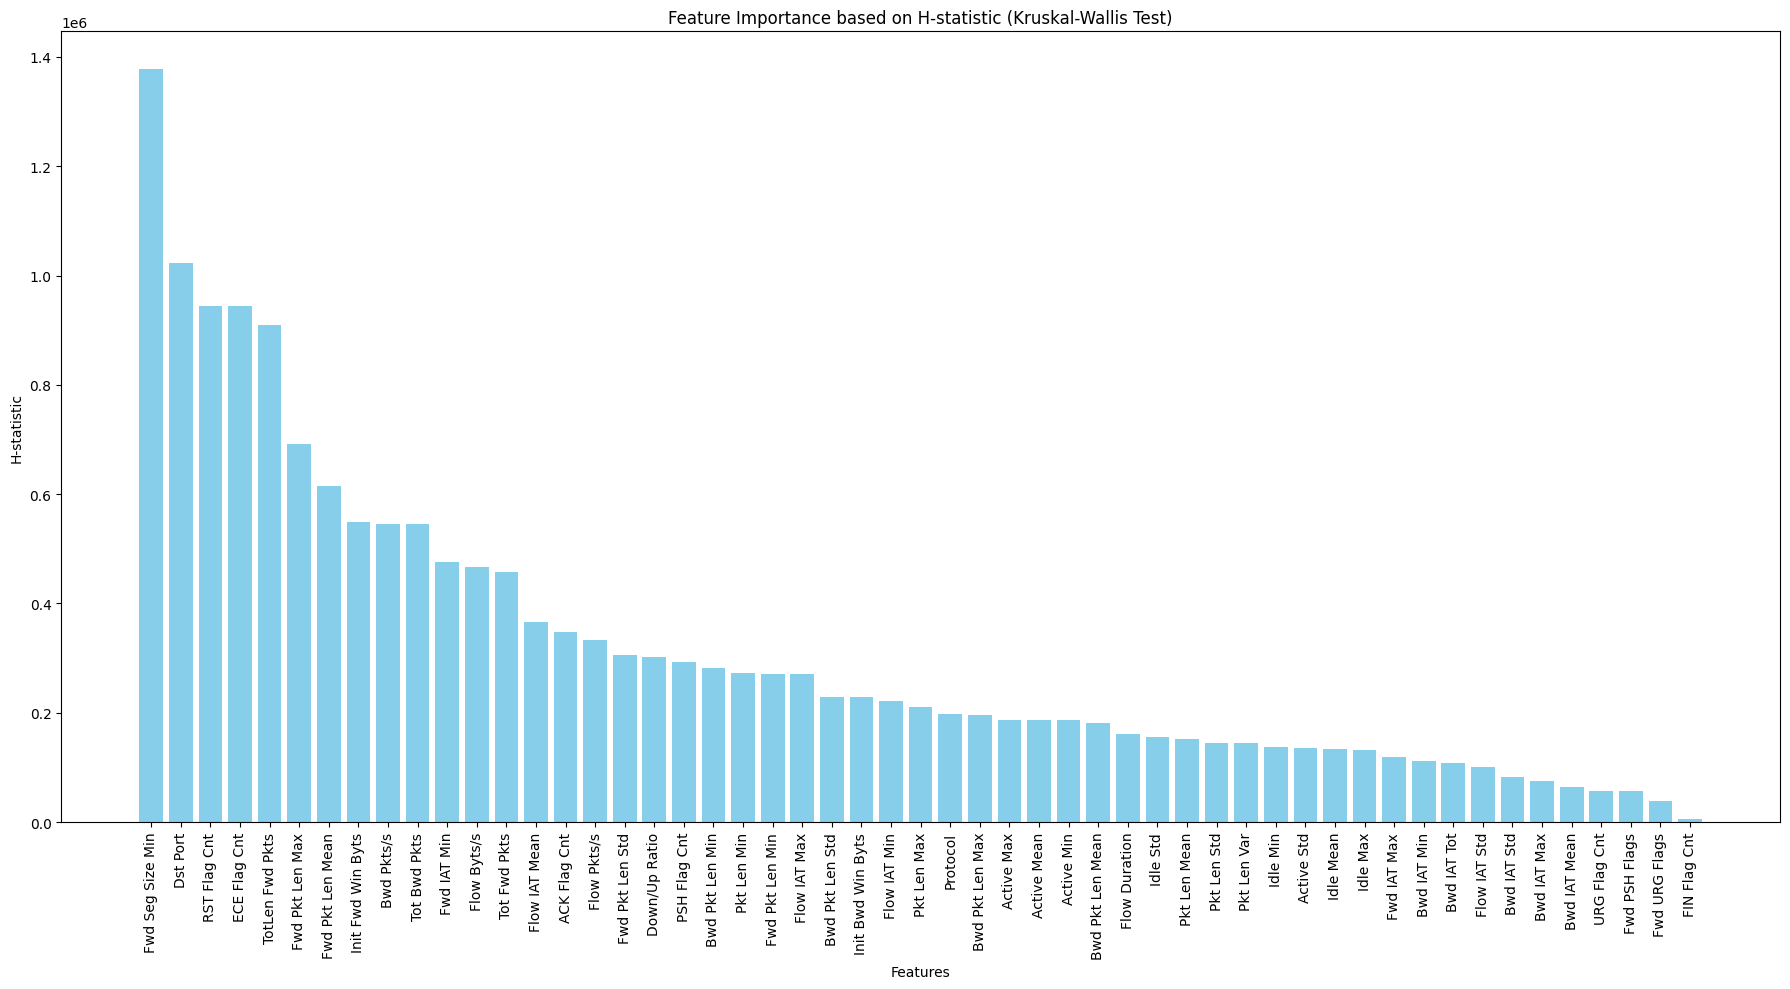

In [50]:
h_p_stats = analyze_feature_importance(df, numeric_features)

In [51]:
def analyze_feature_importance_rf(df, numeric_features, target_col='Attack Type'):
    # Hyperparameter settings
    hyperparameters = {
        'n_estimators': 150,    # Number of trees
        'max_depth': 30,        # Limit tree depth
        'random_state': 42,     # For reproducibility
        'n_jobs': -1            # Use all available cores
    }

    # Prepare the data
    X = df[numeric_features]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

    # Create the Random Forest model with specified hyperparameters
    rf = RandomForestClassifier(**hyperparameters)

    # Fit the model on the training set
    rf.fit(X_train, y_train)

    # Cross-validation on the training set
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
    print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
    
    # Predict on test set
    y_pred = rf.predict(X_test)

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Confusion matrix
    rf_labels = rf.classes_
    cm = confusion_matrix(y_test, y_pred)

    # Calculate test scores
    report = classification_report(y_test, y_pred, target_names=rf_labels)
    print("\nClassification Report:\n")
    print(report, end='\n\n')

    # Plot feature importances
    plt.figure(figsize=(18, 12))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Feature Importance from Random Forest')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return feature_importance_df, cm, rf_labels, cv_scores

Cross-Validation Score: 0.9862 ± 0.0000

Classification Report:

                precision    recall  f1-score   support

           Bot       1.00      1.00      1.00     43361
   Brute Force       1.00      1.00      1.00     28465
          DDoS       1.00      1.00      1.00    232681
           DoS       1.00      1.00      1.00     58907
 Infilteration       0.29      0.10      0.14     41802
Normal Traffic       0.99      1.00      0.99   3028546

      accuracy                           0.99   3433762
     macro avg       0.88      0.85      0.86   3433762
  weighted avg       0.98      0.99      0.98   3433762




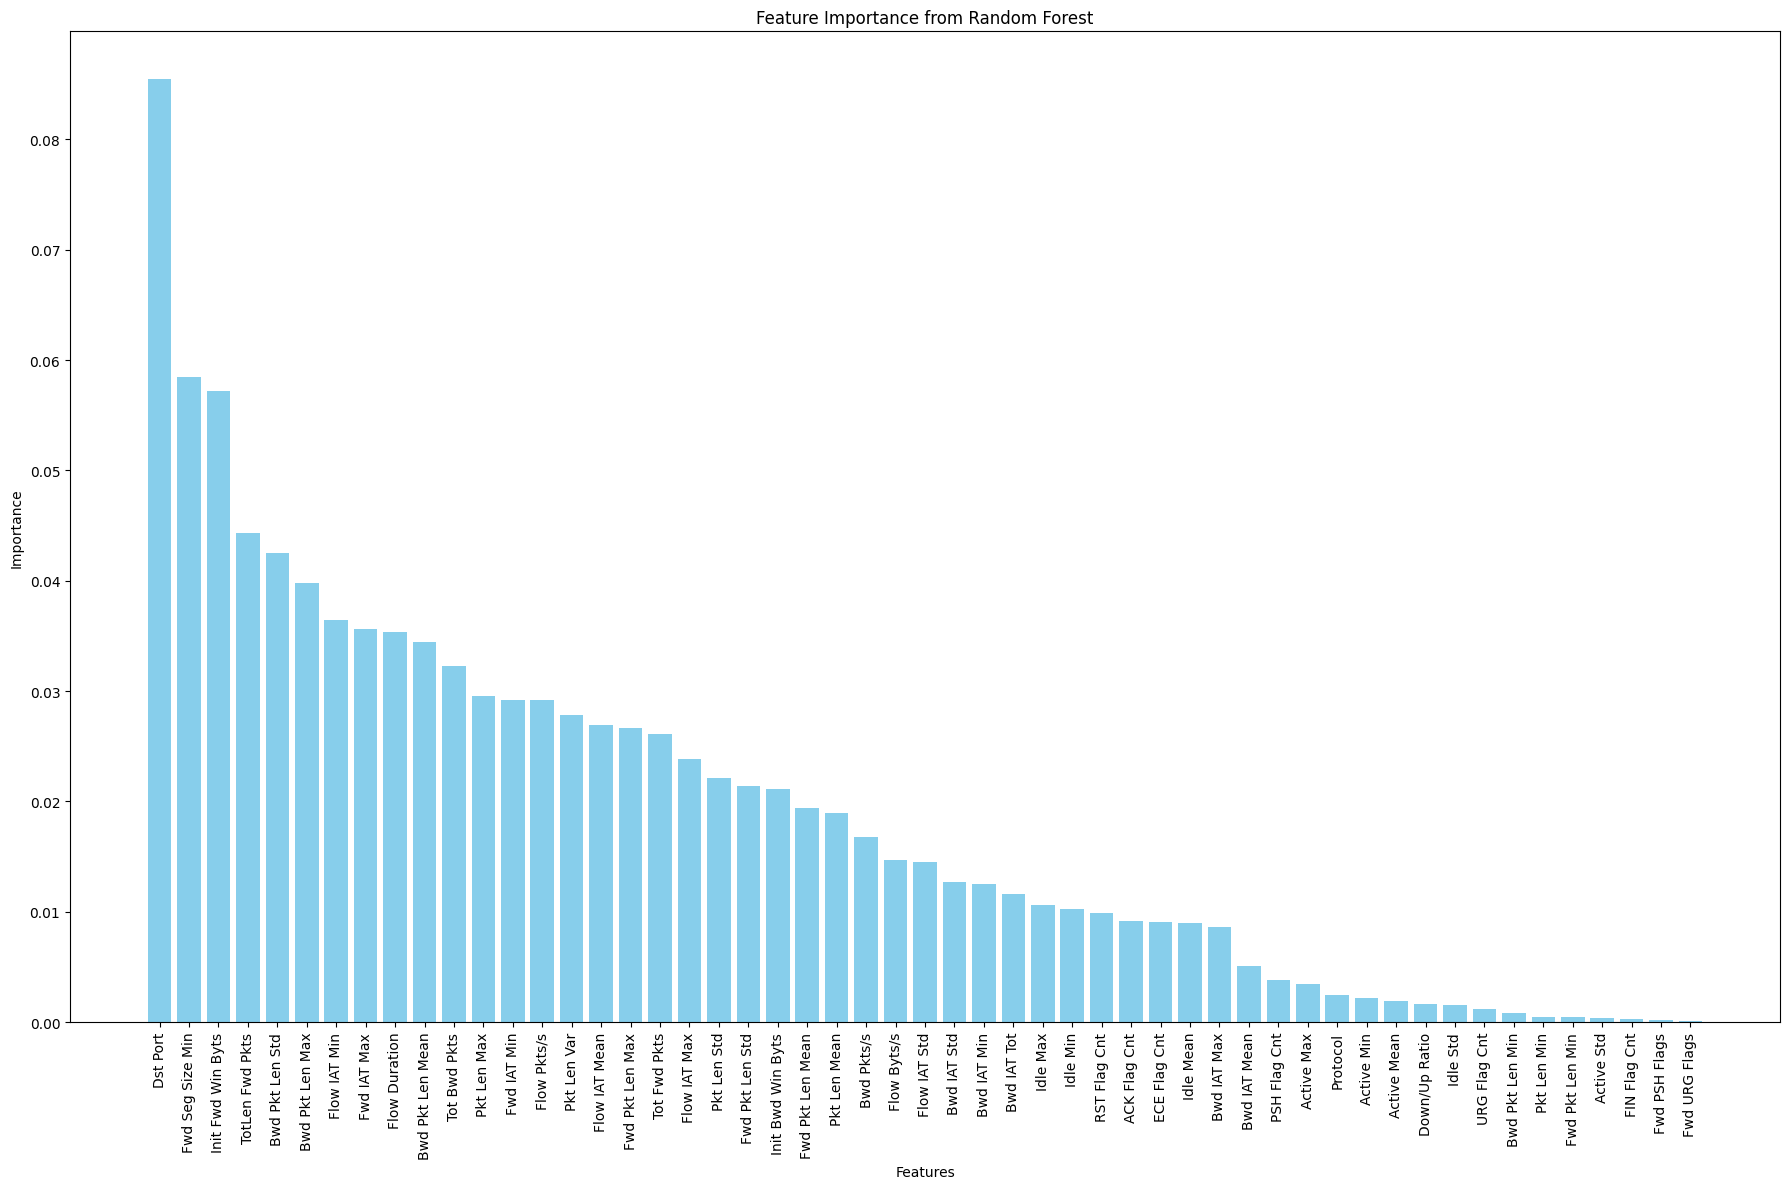

In [52]:
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(df, numeric_features)

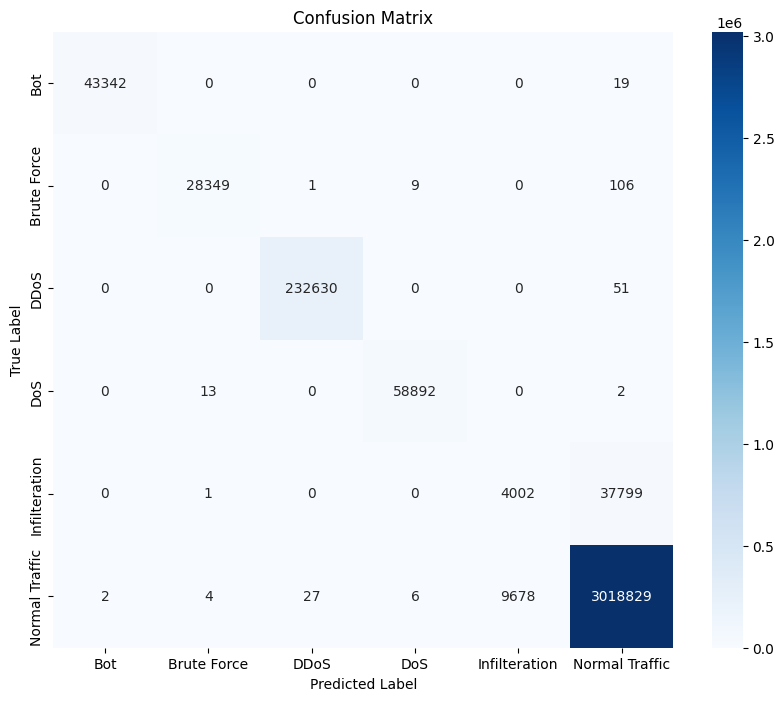

In [53]:
# Evaluating RF performance based on selected features
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_labels, yticklabels=rf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [54]:
# Preparing the df for comparison
h_p_stats.reset_index(inplace = True)
h_p_stats.rename(columns = {'index':'Feature'}, inplace = True)

# Sorting the new df for easier visualization
comparison_tb = feature_importance_tree.merge(h_p_stats, on = 'Feature', how = 'left')
comparison_tb_sorted = comparison_tb.sort_values(by='Importance', ascending=False)
comparison_tb_sorted

,Feature,Importance,H-statistic,p-value
0,Dst Port,0.085524,1.021997e+06,0.0
1,Fwd Seg Size Min,0.058465,1.377856e+06,0.0
2,Init Fwd Win Byts,0.057246,5.493172e+05,0.0
3,TotLen Fwd Pkts,0.044341,9.087771e+05,0.0
4,Bwd Pkt Len Std,0.042550,2.292775e+05,0.0
5,Bwd Pkt Len Max,0.039833,1.959726e+05,0.0
6,Flow IAT Min,0.036447,2.207072e+05,0.0
7,Fwd IAT Max,0.035613,1.199075e+05,0.0
8,Flow Duration,0.035393,1.609992e+05,0.0
9,Bwd Pkt Len Mean,0.034486,1.812817e+05,0.0


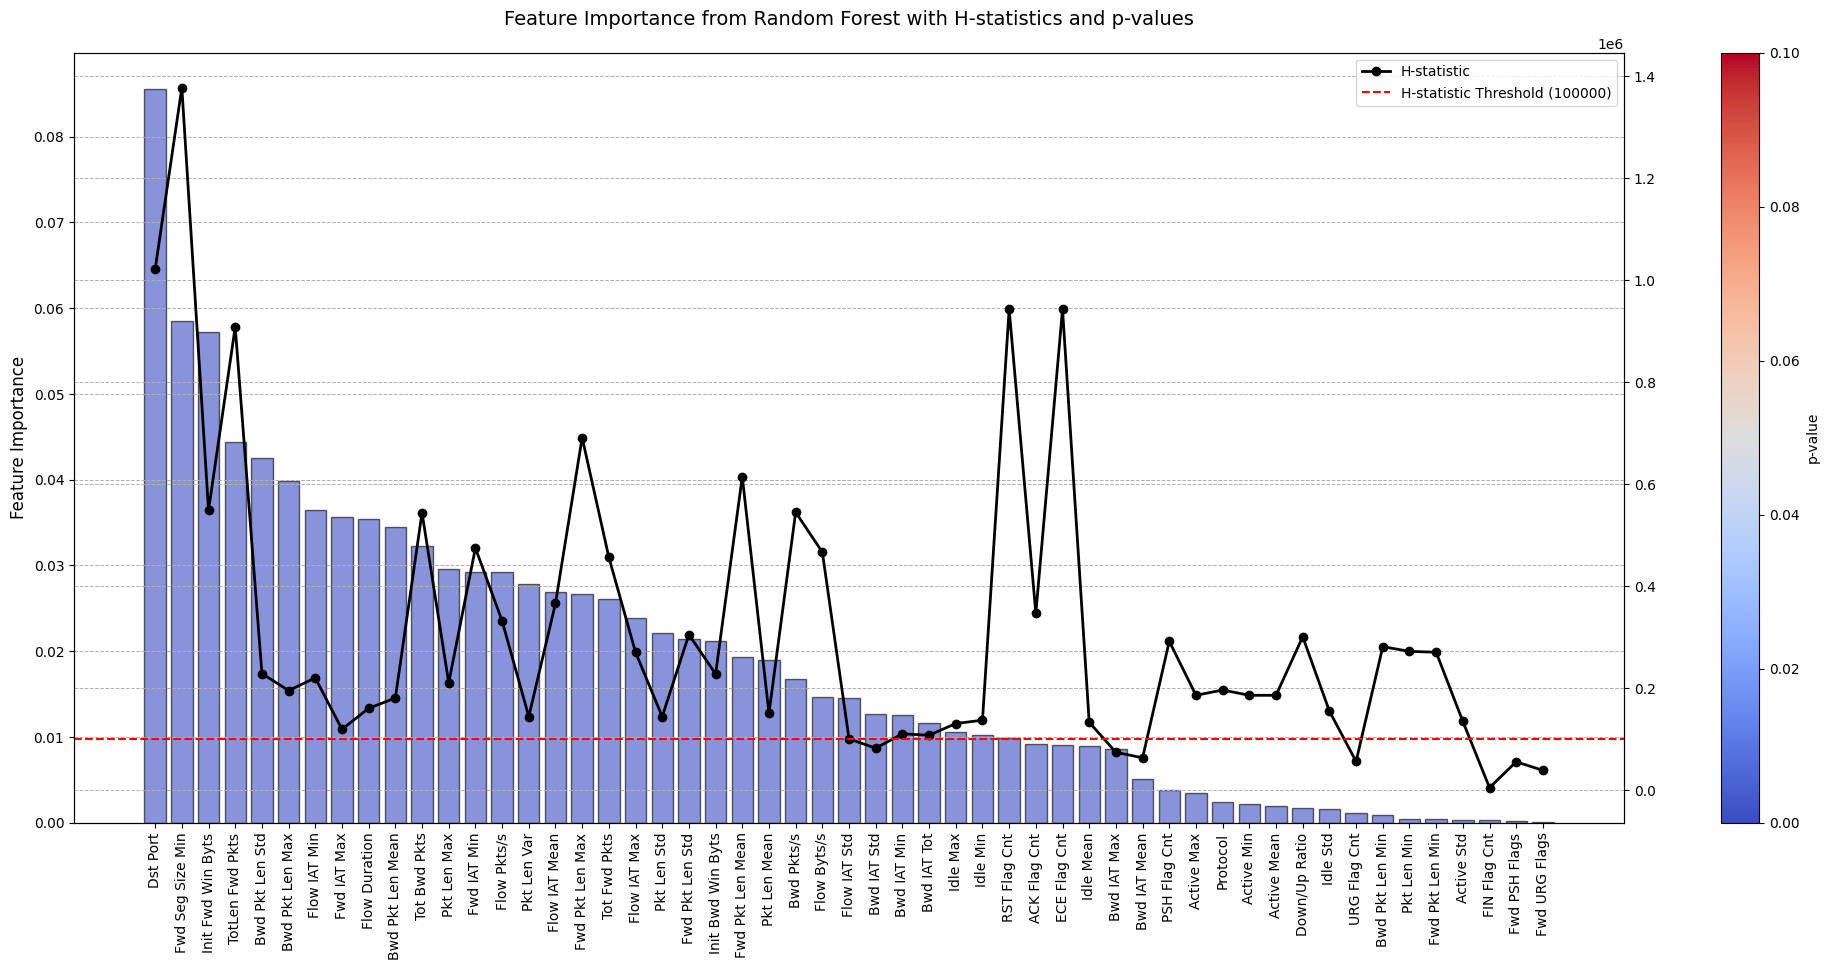

In [55]:
# Create figure and axis
plt.figure(figsize=(25, 10))

# Create a color map based on p-value
colors = sns.color_palette("coolwarm", as_cmap=True)

# Create twin axes for different scales
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot bars for importance
bars = ax1.bar(comparison_tb_sorted['Feature'],
                comparison_tb_sorted['Importance'],
                alpha=0.6,
                color=[colors(0 + (value)) for value in comparison_tb_sorted['p-value']], edgecolor='black')

# Plot line for H-statistic
line = ax2.plot(comparison_tb_sorted['Feature'],
                 comparison_tb_sorted['H-statistic'],
                 color='black',
                 linewidth=2,
                 label='H-statistic',
                 marker='o')

# Add a horizontal threshold line
threshold = 100000
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'H-statistic Threshold ({threshold})')
ax2.legend()

# Customize primary y-axis (Importance)
ax1.set_ylabel('Feature Importance', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set x-ticks and labels
ax1.set_xticks(range(len(comparison_tb_sorted['Feature'])))
ax1.set_xticklabels(comparison_tb_sorted['Feature'], rotation=90, ha='center', fontsize=10)

# Add title
plt.title('Feature Importance from Random Forest with H-statistics and p-values',
          fontsize=14, pad=20)

# Add colorbar for p-values
sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=comparison_tb_sorted['p-value'].min(), vmax=0.1))
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('p-value', fontsize=10)

# Add gridlines for readability
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.show()

In [56]:
df.to_csv('cicids2018_before_drop_nonimportant_features.csv', index=False)

In [57]:
df.shape

(11445871, 54)

In [58]:
# Removing statiscally irrelavant features from the dataset
cols_to_remove = ['Fwd URG Flags', 'Fwd PSH Flags', 'FIN Flag Cnt', 'Active Std', 'Fwd Pkt Len Min', 'Pkt Len Min', 'Bwd Pkt Len Min', 'URG Flag Cnt', 'Idle Std', 'Down/Up Ratio', 'Active Mean', 'Active Min', 'Protocol', 'Active Max', 'PSH Flag Cnt', 'Bwd IAT Max', 'Bwd IAT Mean', 'Idle Mean', 'ECE Flag Cnt', 'ACK Flag Cnt']
df.drop(columns=cols_to_remove, inplace=True)

In [59]:
df.shape

(11445871, 34)

In [60]:
eval_dataset_w_RF(df, target_column='Attack Type')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    8.2s finished


Cross validation average score: 0.9865 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9864
Resource measurements: {'Training Time (s)': 397.3292202949524, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 94.35803523758676}
                precision    recall  f1-score   support

           Bot       1.00      0.99      0.99     43361
   Brute Force       1.00      0.99      0.99     28465
          DDoS       1.00      0.99      0.99    232681
           DoS       1.00      1.00      1.00     58907
 Infilteration       0.66      0.00      0.00     41802
Normal Traffic       0.99      1.00      0.99   3028546

      accuracy                           0.99   3433762
     macro avg       0.94      0.83      0.83   3433762
  weighted avg       0.98      0.99      0.98   3433762



In [61]:
df.to_csv('cicids2018_after_drop_nonimportant_features.csv', index=False)

In [67]:
df = pd.read_csv("cicids2018_before_drop_nonimportant_features.csv")

In [68]:
df.drop(columns=["Dst Port", "Init Fwd Win Byts"], inplace=True)

In [69]:
numeric_features, categorical_features = get_feature_types(df, target_col='Attack Type')

Cross-Validation Score: 0.9829 ± 0.0000

Classification Report:

                precision    recall  f1-score   support

           Bot       1.00      0.99      1.00     43361
   Brute Force       1.00      1.00      1.00     28465
          DDoS       0.97      0.97      0.97    232681
           DoS       0.99      1.00      0.99     58907
 Infilteration       0.31      0.07      0.12     41802
Normal Traffic       0.99      1.00      0.99   3028546

      accuracy                           0.98   3433762
     macro avg       0.88      0.84      0.84   3433762
  weighted avg       0.98      0.98      0.98   3433762




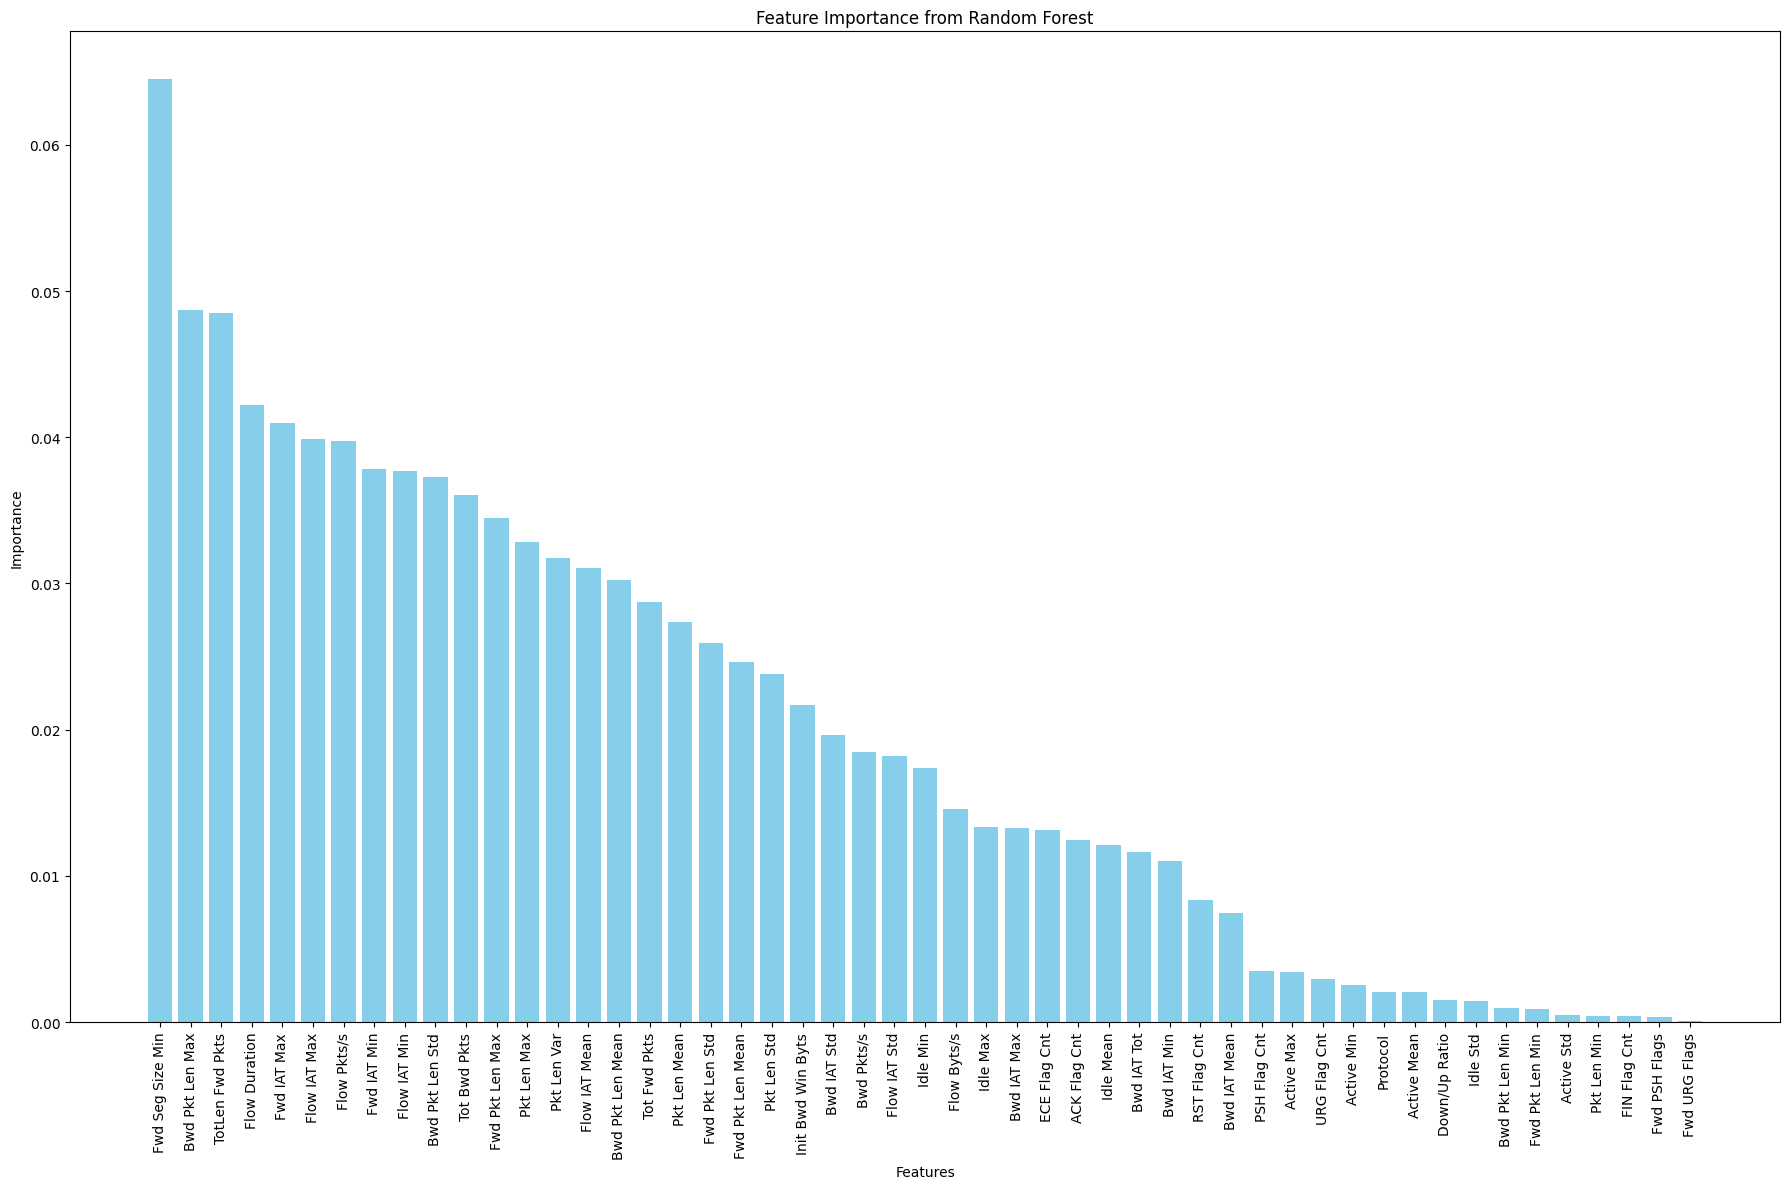

In [70]:
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(df, numeric_features)

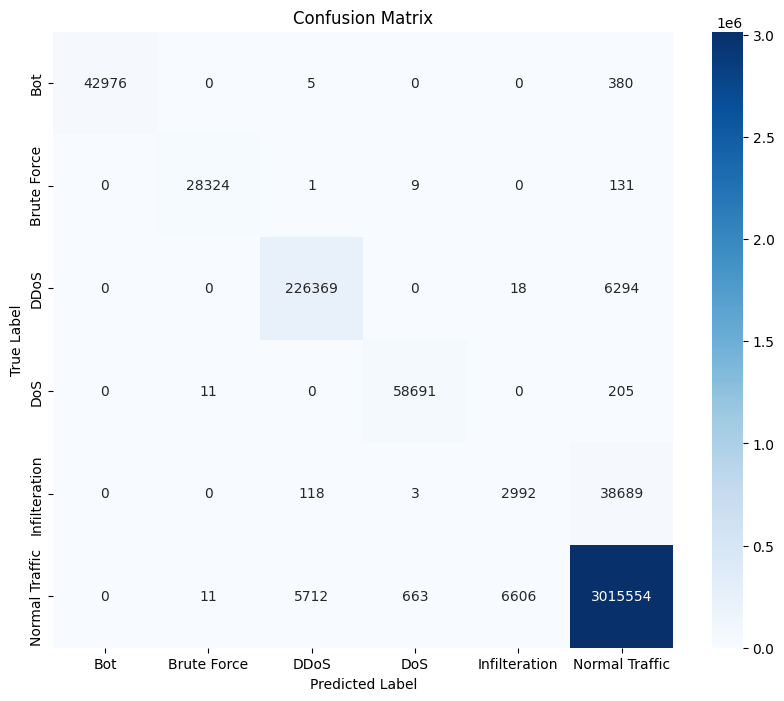

In [72]:
# Evaluating RF performance based on selected features
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_labels, yticklabels=rf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

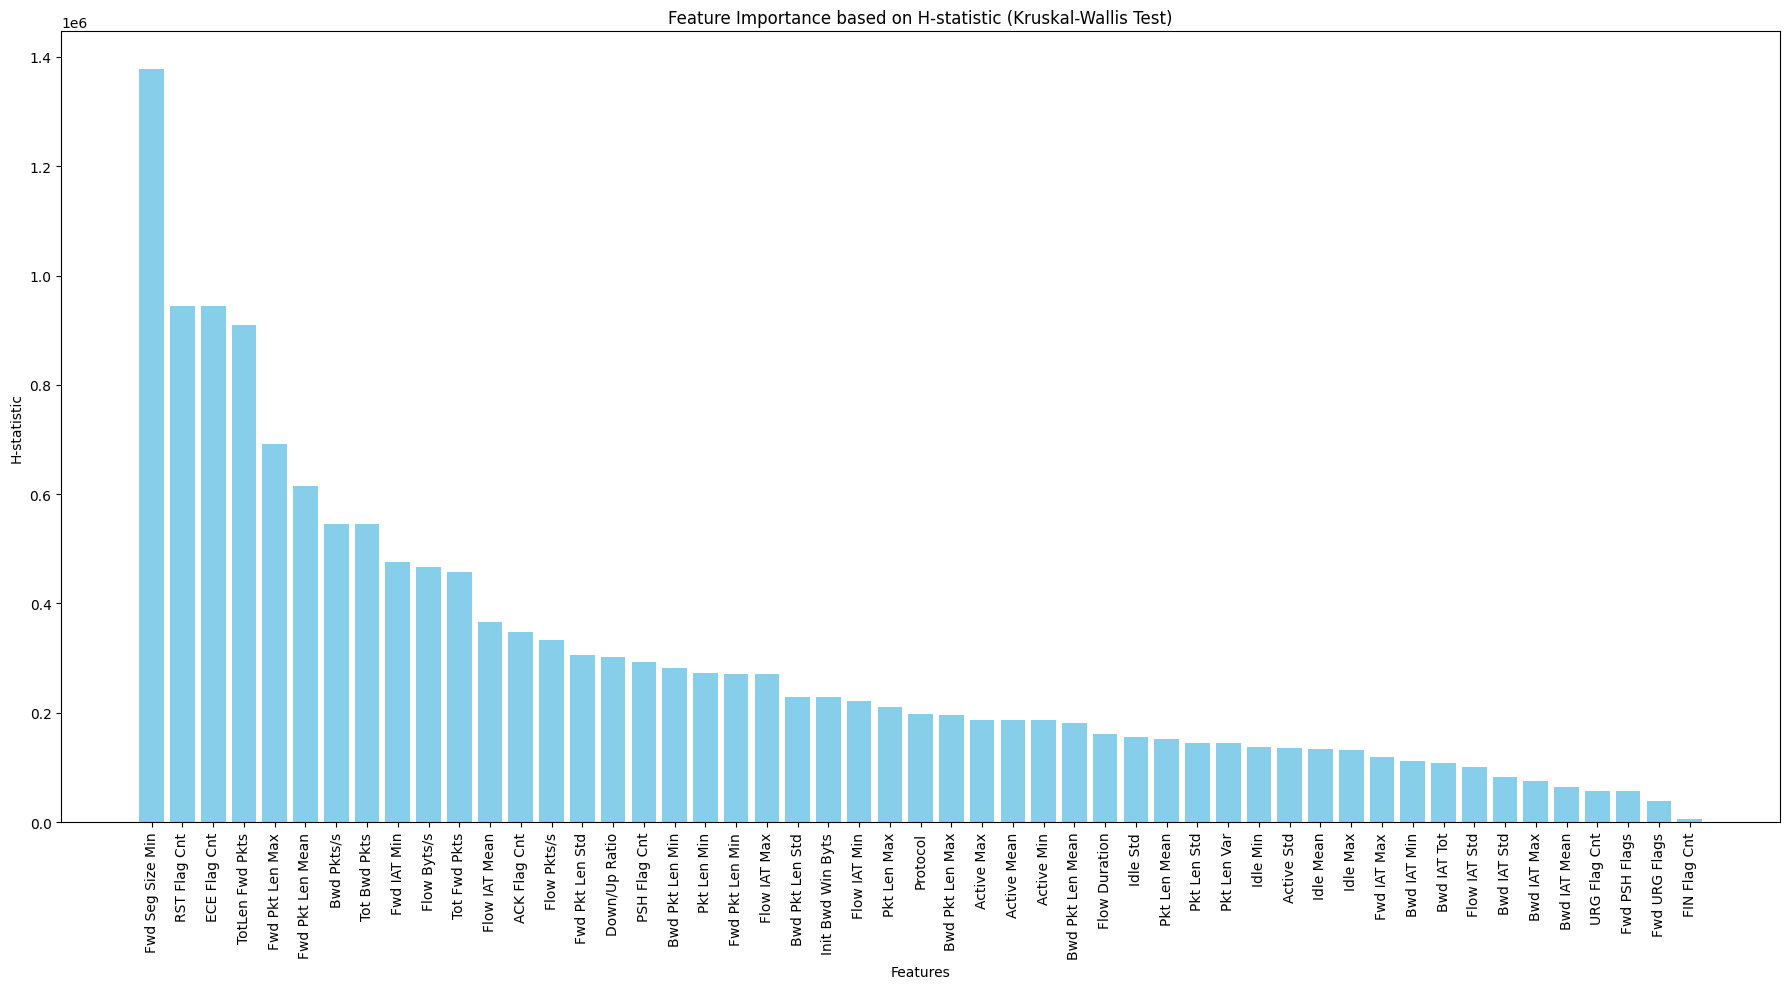

In [73]:
h_p_stats = analyze_feature_importance(df, numeric_features)

In [74]:
# Preparing the df for comparison
h_p_stats.reset_index(inplace = True)
h_p_stats.rename(columns = {'index':'Feature'}, inplace = True)

# Sorting the new df for easier visualization
comparison_tb = feature_importance_tree.merge(h_p_stats, on = 'Feature', how = 'left')
comparison_tb_sorted = comparison_tb.sort_values(by='Importance', ascending=False)
comparison_tb_sorted

,Feature,Importance,H-statistic,p-value
0,Fwd Seg Size Min,0.064535,1.377856e+06,0.0
1,Bwd Pkt Len Max,0.048697,1.959726e+05,0.0
2,TotLen Fwd Pkts,0.048519,9.087771e+05,0.0
3,Flow Duration,0.042212,1.609992e+05,0.0
4,Fwd IAT Max,0.041000,1.199075e+05,0.0
5,Flow IAT Max,0.039848,2.709023e+05,0.0
6,Flow Pkts/s,0.039770,3.326221e+05,0.0
7,Fwd IAT Min,0.037824,4.753182e+05,0.0
8,Flow IAT Min,0.037675,2.207072e+05,0.0
9,Bwd Pkt Len Std,0.037250,2.292775e+05,0.0


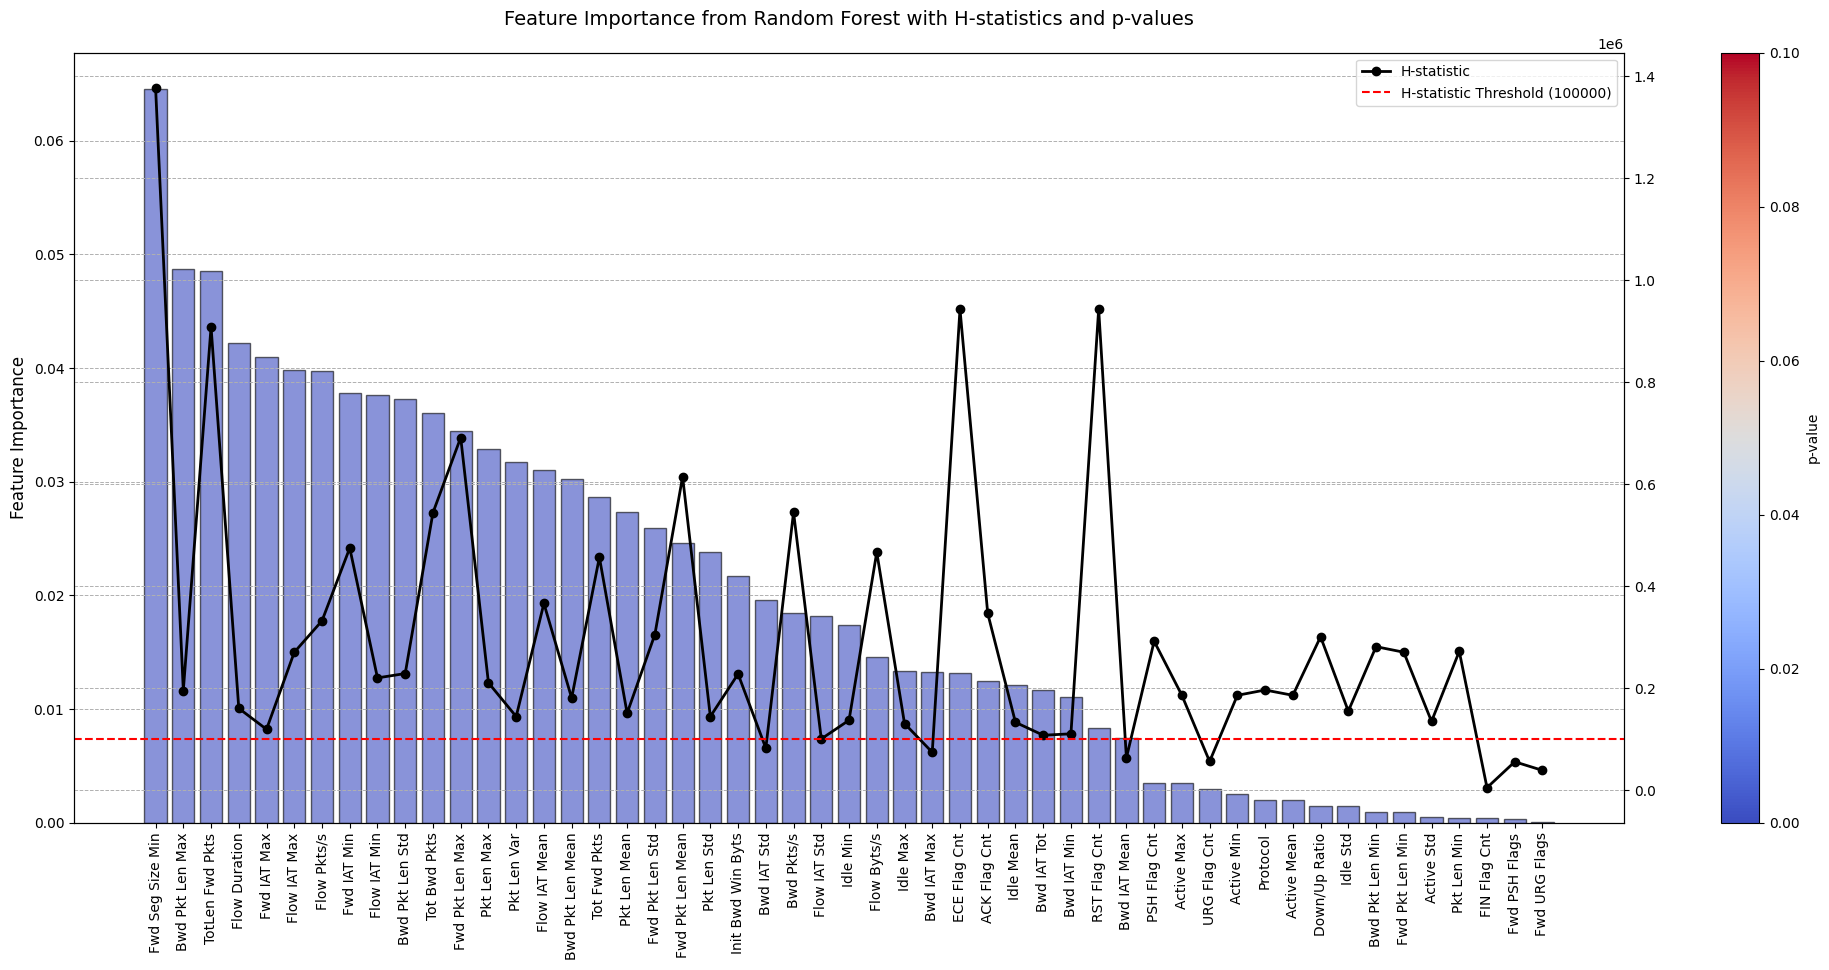

In [75]:
# Create figure and axis
plt.figure(figsize=(25, 10))

# Create a color map based on p-value
colors = sns.color_palette("coolwarm", as_cmap=True)

# Create twin axes for different scales
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot bars for importance
bars = ax1.bar(comparison_tb_sorted['Feature'],
                comparison_tb_sorted['Importance'],
                alpha=0.6,
                color=[colors(0 + (value)) for value in comparison_tb_sorted['p-value']], edgecolor='black')

# Plot line for H-statistic
line = ax2.plot(comparison_tb_sorted['Feature'],
                 comparison_tb_sorted['H-statistic'],
                 color='black',
                 linewidth=2,
                 label='H-statistic',
                 marker='o')

# Add a horizontal threshold line
threshold = 100000
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'H-statistic Threshold ({threshold})')
ax2.legend()

# Customize primary y-axis (Importance)
ax1.set_ylabel('Feature Importance', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set x-ticks and labels
ax1.set_xticks(range(len(comparison_tb_sorted['Feature'])))
ax1.set_xticklabels(comparison_tb_sorted['Feature'], rotation=90, ha='center', fontsize=10)

# Add title
plt.title('Feature Importance from Random Forest with H-statistics and p-values',
          fontsize=14, pad=20)

# Add colorbar for p-values
sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=comparison_tb_sorted['p-value'].min(), vmax=0.1))
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('p-value', fontsize=10)

# Add gridlines for readability
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.show()

In [76]:
df.to_csv('cicids2018_before_major_feat_select.csv', index=False)

In [77]:
df.shape

(11445871, 52)

In [80]:
not_important_columns = ['Fwd URG Flags', 'Fwd PSH Flags', 'FIN Flag Cnt', 'Pkt Len Min', 'Active Std', 'Fwd Pkt Len Min', 'Bwd Pkt Len Min', 'Idle Std', 'Down/Up Ratio', 'Active Mean', 'Protocol', 'Active Min', 'URG Flag Cnt', 'Active Max', 'PSH Flag Cnt', 'Bwd IAT Mean']
df.drop(columns=not_important_columns, axis=1, inplace=True)

In [81]:
df.shape

(11445871, 36)

In [82]:
df.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Pkts/s',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'RST Flag Cnt', 'ACK Flag Cnt', 'ECE Flag Cnt', 'Init Bwd Win Byts',
       'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min', 'Attack Type'],
      dtype='object')

In [83]:
eval_dataset_w_RF(df, target_column='Attack Type')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    8.3s finished


Cross validation average score: 0.9798 +/- standard deviation: 0.0002
Accuracy on the test set: 0.9796
Resource measurements: {'Training Time (s)': 367.60059094429016, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 93.73311475409837}
                precision    recall  f1-score   support

           Bot       1.00      0.99      0.99     43361
   Brute Force       1.00      0.99      0.99     28465
          DDoS       0.99      0.90      0.94    232681
           DoS       0.99      0.95      0.97     58907
 Infilteration       0.71      0.00      0.00     41802
Normal Traffic       0.98      1.00      0.99   3028546

      accuracy                           0.98   3433762
     macro avg       0.94      0.81      0.82   3433762
  weighted avg       0.98      0.98      0.97   3433762



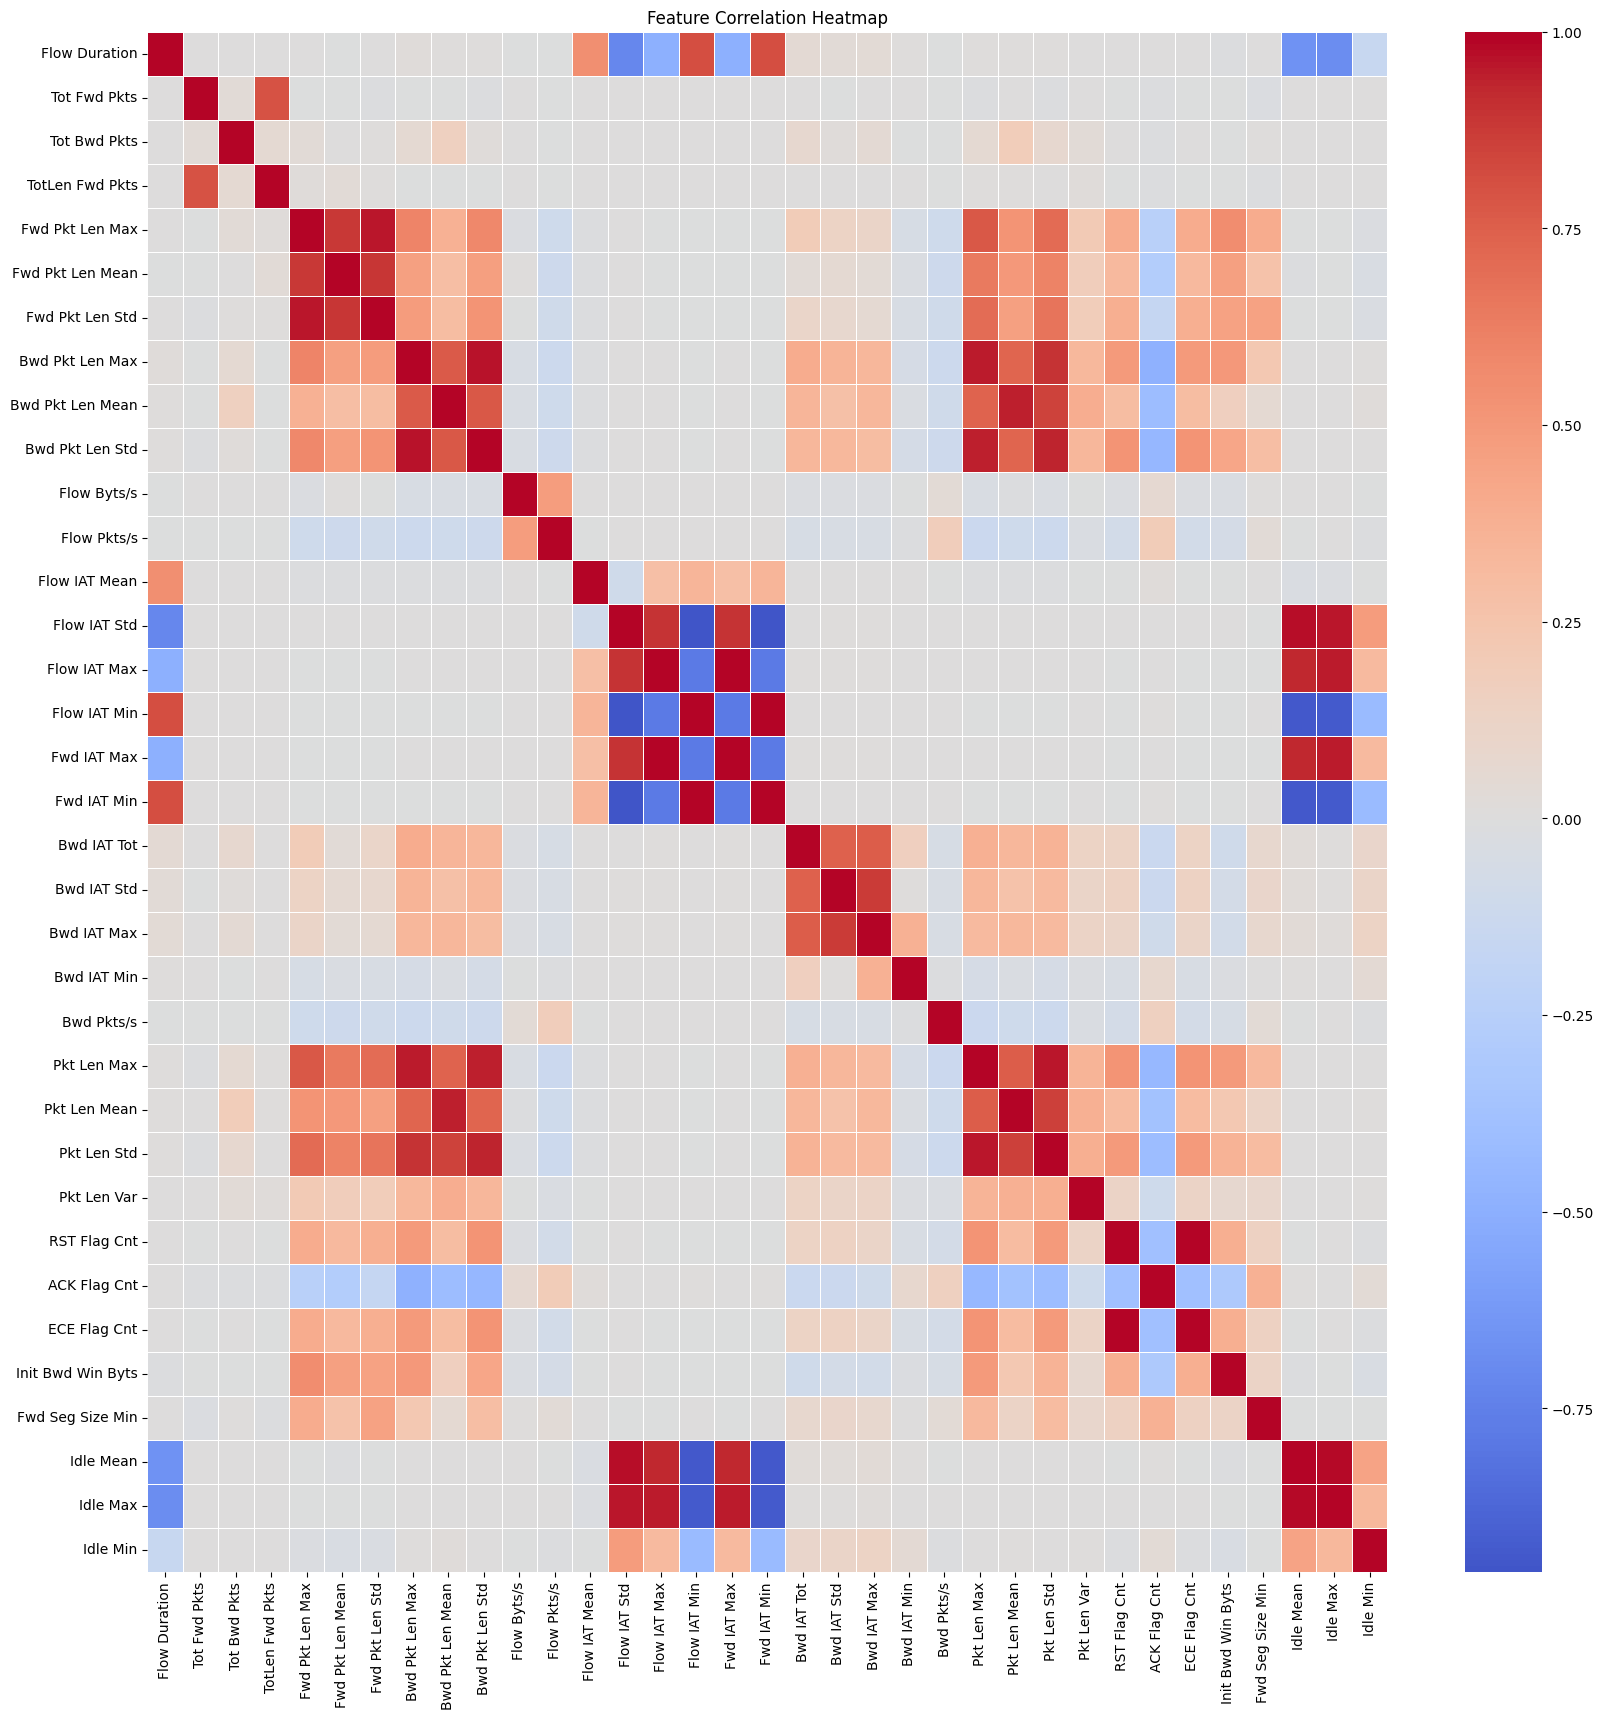

In [84]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(df, target_col='Attack Type')
high_corr = correlation_analysis(df, numeric_features)

In [85]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Fwd Pkt Len Max has a high correlation with Fwd Pkt Len Mean: 0.8796
Fwd Pkt Len Max has a high correlation with Fwd Pkt Len Std: 0.9547
Fwd Pkt Len Mean has a high correlation with Fwd Pkt Len Std: 0.8911
Bwd Pkt Len Max has a high correlation with Bwd Pkt Len Std: 0.9661
Bwd Pkt Len Max has a high correlation with Pkt Len Max: 0.9496
Bwd Pkt Len Max has a high correlation with Pkt Len Std: 0.8995
Bwd Pkt Len Mean has a high correlation with Pkt Len Mean: 0.9437
Bwd Pkt Len Std has a high correlation with Pkt Len Max: 0.9438
Bwd Pkt Len Std has a high correlation with Pkt Len Std: 0.9373
Flow IAT Std has a high correlation with Flow IAT Max: 0.8957
Flow IAT Std has a high correlation with Flow IAT Min: -0.9576
Flow IAT Std has a high correlation with Fwd IAT Max: 0.8957
Flow IAT Std has a high correlation with Fwd IAT Min: -0.9576
Flow IAT Std has a high correlation with Idle Mean: 0.9746
Flow IAT Std has a high correlation with Idle Max: 0.9565
Flow IAT Max has a high correlation wit

In [86]:
df.shape

(11445871, 36)

In [87]:
df.to_csv('cicids2018_before_second_corr_analysis.csv', index=False)

In [88]:
high_corr_columns = ["Fwd IAT Min", "ECE Flag Cnt", "Idle Max", "Fwd IAT Max", "Idle Mean", "Pkt Len Std", "Bwd Pkt Len Std", "Fwd Pkt Len Std", "Flow IAT Min", "Fwd IAT Min"]

In [89]:
df.drop(columns=high_corr_columns, axis=1, inplace=True)

In [90]:
df.shape

(11445871, 27)

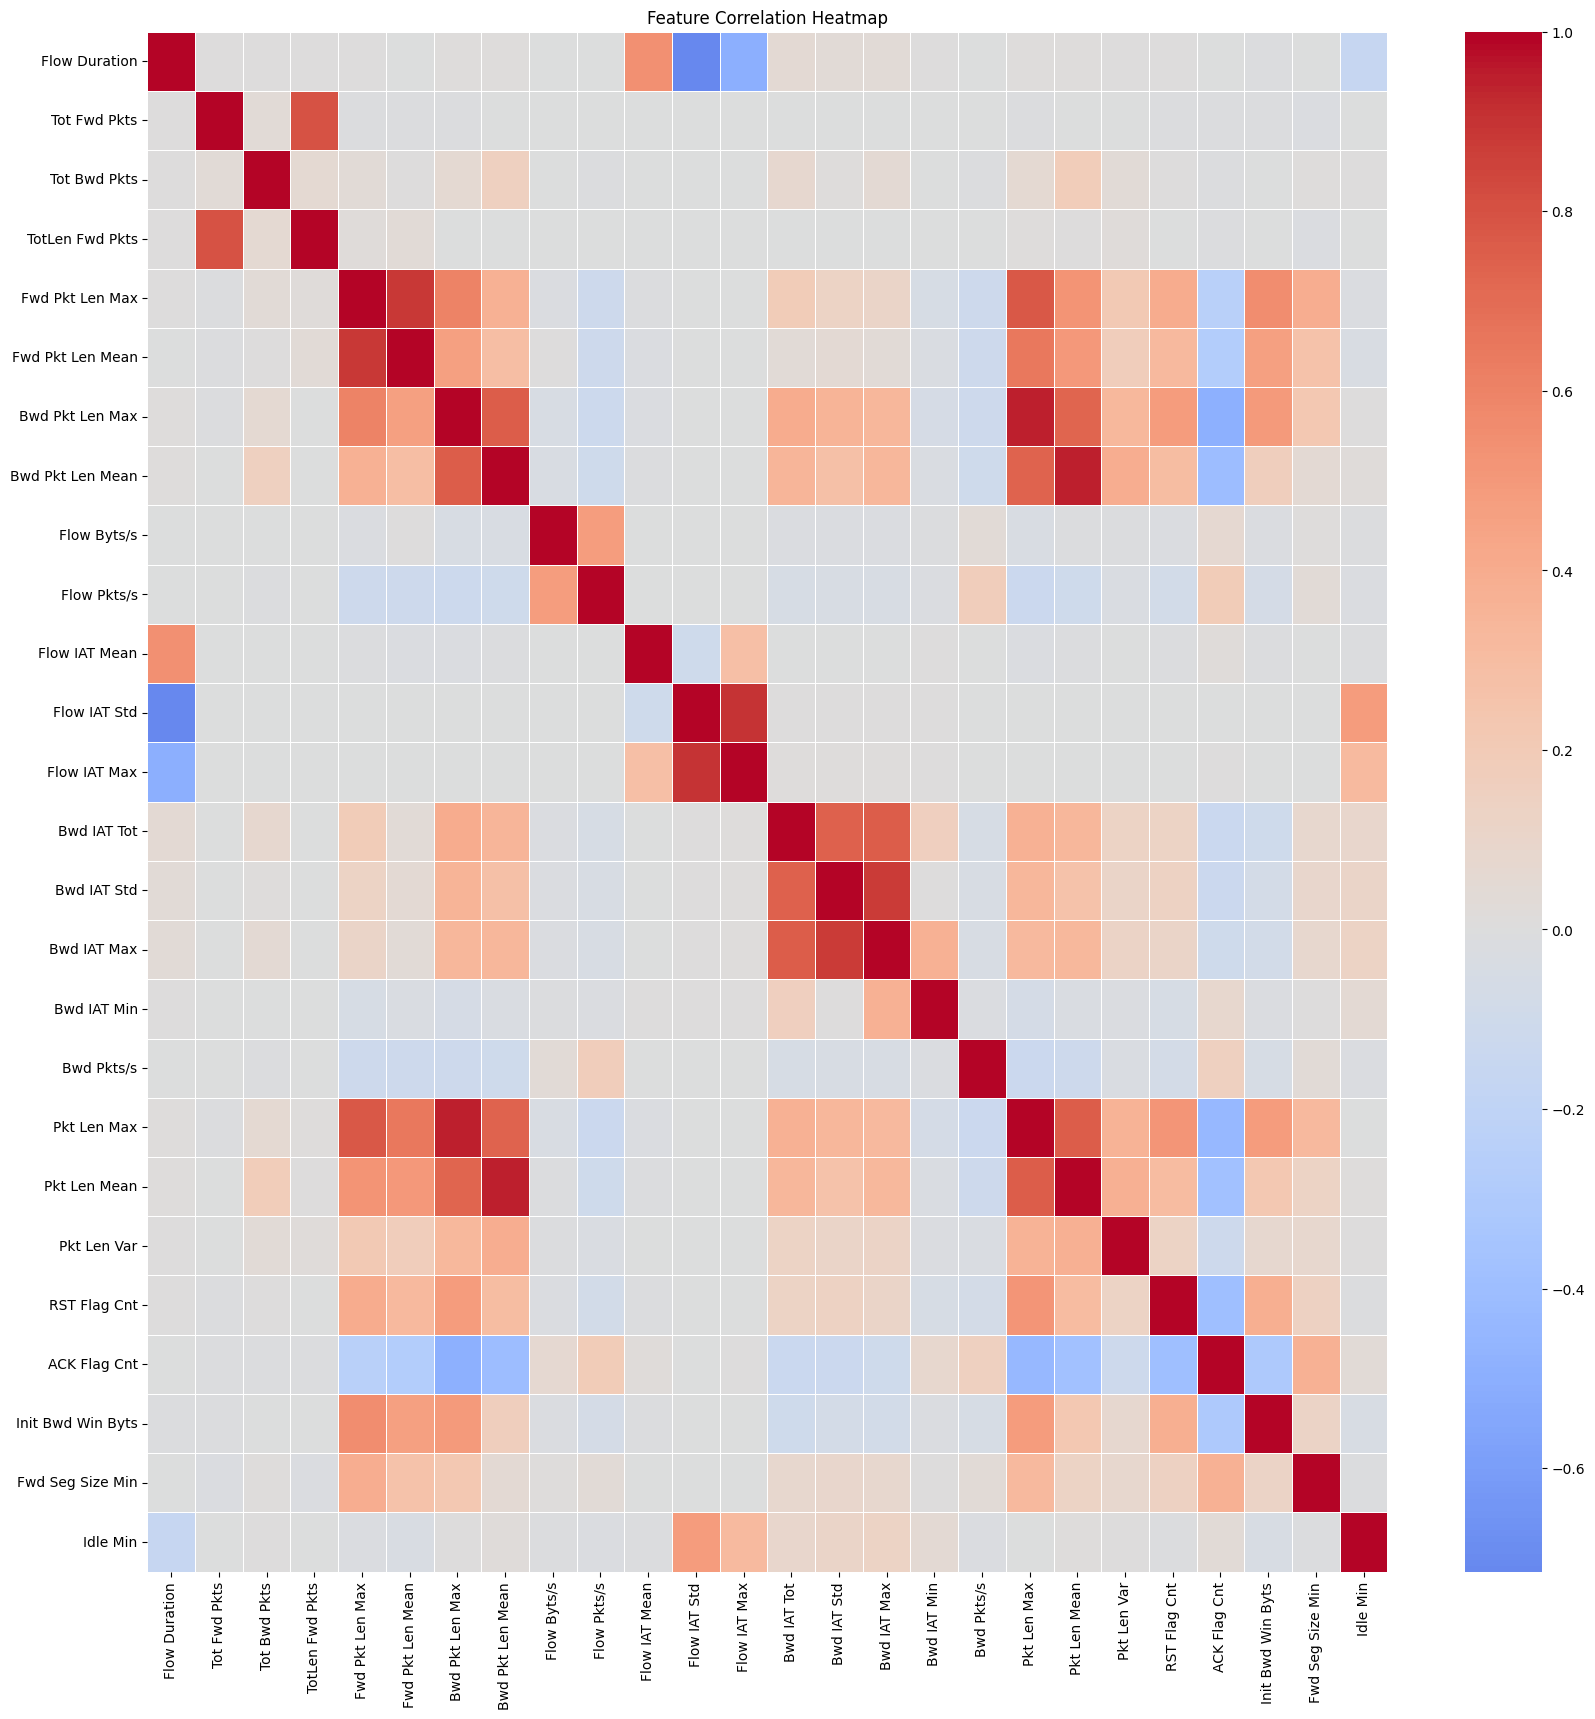

In [91]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(df, target_col='Attack Type')
high_corr = correlation_analysis(df, numeric_features)

In [92]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Fwd Pkt Len Max has a high correlation with Fwd Pkt Len Mean: 0.8796
Bwd Pkt Len Max has a high correlation with Pkt Len Max: 0.9496
Bwd Pkt Len Mean has a high correlation with Pkt Len Mean: 0.9437
Flow IAT Std has a high correlation with Flow IAT Max: 0.8957
Bwd IAT Std has a high correlation with Bwd IAT Max: 0.8764


In [93]:
additional_columns_high_corr = ["Pkt Len Max", "Pkt Len Mean"]
df.drop(columns=additional_columns_high_corr, axis=1, inplace=True)

In [94]:
df.to_csv('cicids2018_almost_final.csv', index=False)

In [95]:
df.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Bwd IAT Tot', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Pkts/s', 'Pkt Len Var',
       'RST Flag Cnt', 'ACK Flag Cnt', 'Init Bwd Win Byts', 'Fwd Seg Size Min',
       'Idle Min', 'Attack Type'],
      dtype='object')

In [ ]:
eval_dataset_w_RF(df, target_column='Attack Type')

In [97]:
numeric_features, categorical_features = get_feature_types(df, target_col='Attack Type')

In [ ]:
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(df, numeric_features)